# Controlling RNNs with constant input

Note: the MINDy models are not provided here as they are derived from human fMRI data, but they can be obtained upon request.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from Synthesis import *
from visualizations import *
from torch import Tensor
from typing import Tuple, Any
import os

# Pytorch settings
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)
dvc = "cuda" if torch.cuda.is_available() else "cpu"

# Figure settings
renaming = {"backward_nominal_state": "Backward nominal state", "forward_nominal_state": "Forward nominal state",
            "backward_push": "Backward push", "forward_pull": "Forward pull", "linearized": "Linearized at x0", "linearized_origin": "Linearized at origin",
            "backward_initial_state": "Backward initial state", "forward_final_state": "Forward final state", "naive": "Naive"}
plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'figure.figsize': (8, 6)})
plt.rcParams.update({'figure.dpi': 300})
figdir = "figures"
os.makedirs(figdir, exist_ok=True)

# Pandas output settings
pd.set_option('display.max_columns', None)

# Data output directory
datdir = "data"
os.makedirs(datdir, exist_ok=True)

## Utility functions

### Experiment-related functions

Function to get `x1` given the model, horizon, and initial state:

In [ ]:
def get_x1(mdl: nn.Module, x0: Tensor, B: Tensor, T: float = 1.,
           scaling: float = 1, method: str = "random", odeint_kwargs = {}) -> Tensor:
    """Get target state `x1`

    Parameters
    ----------
    mdl : nn.Module
        The model to synthesize control for.
    x0 : Tensor (nTrials, d)
        The initial state of the system.
    B : Tensor (d, k)
        The input matrix for the control synthesis.
    T : float
        The time horizon for the control synthesis.
    scaling : float
        Scaling factor. Default is 1.
    method : str
        The method to use for generating the target state. Options are:
        - "random": Normal distribution with mean 0 and std `scaling`.
        - "perturbation": Add a random perturbation to `x0` with std
            `scaling`.
        - "drift_perturbation": Add a random perturbation with std
            `scaling` to the drift final state `PhiTx0`.
        - "numeric_reachable": Use a random input with std `scaling`
            to get the controlled final state at time `T`.
        - "approx_reachable": Use the approximation of reachable set
            given by the forward nominal state synthesis where the
            random vector has zero mean and std `scaling`. Detailed
            in later sections. Only valid for input matrix consisting
            one-hot vectors.
    
    Returns
    -------
    x1 : Tensor (nTrials, d)
        The target state.
    """
    if method == "random":
        return torch.randn_like(x0) * scaling  # Random target state
    elif method == "perturbation":
        return x0 + torch.randn_like(x0) * scaling
    
    dvc = x0.device
    N = x0.shape[-1]
    old_shape = x0.shape
    x0 = x0.reshape(-1, N)
    fullT = torch.tensor([0, T], dtype=default_dtype).to(dvc)

    if method == "drift_perturbation":
        PhiTx0 = odeint(mdl, x0, fullT, **odeint_kwargs)[-1]
        x1 = PhiTx0 + torch.randn_like(PhiTx0) * scaling
        x1 = x1.reshape(old_shape)
        return x1
    
    elif method == "numeric_reachable":
        u = torch.randn(x0.shape[0], B.shape[-1], device=dvc, dtype=default_dtype) * scaling  # Random input
        cMdl = ControlledMdl(mdl, u @ B.T)  # Controlled model with random input
        x1 = odeint(cMdl, x0, fullT, **odeint_kwargs)[-1]  # Simulate to get target state
        x1 = x1.reshape(old_shape)
        return x1
    
    elif method == "approx_reachable":
        DN = vmap(jacrev(lambda x: mdl(None, x)))
        idx = torch.linalg.vector_norm(B, dim=-1) < 1e-8

        PhiTx0 = odeint(mdl, x0, fullT, **odeint_kwargs)[-1]

        if torch.any(idx):        
            DNPhiTx0 = DN(PhiTx0)  # (nTrials, d, d)
            ATx0 = torch.linalg.solve(torch.linalg.matrix_exp(T * DNPhiTx0) - torch.eye(N, dtype=default_dtype, device=dvc), DNPhiTx0)  # (nTrials, d, d)
            M = ATx0[..., idx, :]  # (nTrials, d - k, d)
            Q, _ = torch.linalg.qr(torch.permute(M, [0, 2, 1]), mode="complete")  # (nTrials, d, d), (nTrials, d, d - k)
            Q2 = Q[..., -(M.shape[-1] - M.shape[-2]):, ]  # (nTrials, d, k)
            xi = torch.randn([Q2.shape[0], Q2.shape[-1], 1], device=dvc, dtype=default_dtype) * scaling  # (nTrials, k, 1)
            x1 = PhiTx0 + torch.squeeze(Q2 @ xi, -1)  # (nTrials, d)
            x1 = x1.reshape(old_shape)
        else:
            x1 = PhiTx0 + torch.randn_like(PhiTx0) * scaling

        return x1
    
    else:
        raise ValueError(f"Unknown method {method} for generating target state x1.")

Functions to obtain synthesized input and endpoint error:

In [3]:
def get_err(mdl: nn.Module, x0: Tensor, x1: Tensor, T: float = 30, B: Tensor | None = None,
            methods: Sequence[str] = ("backward_nominal_state", "forward_nominal_state", "linearized"),
            odeint_kwargs: dict = {}, **kwargs) -> Tuple[dict, dict, dict]:
    """
    Get the performance measures for the control synthesis.

    Parameters
    ----------
    mdl : nn.Module
        The model to synthesize control for.
    x0 : Tensor
        The initial state of the system.
    x1 : Tensor
        The target state of the system.
    T : float
        The time horizon for the control synthesis.
    B : Tensor | None
        The input matrix for the control synthesis. If None, assumed to be an identity matrix.
    methods : Sequence[str]
        The methods to use for control synthesis. Default is ("backward_push", "forward_pull", "linearized").
    odeint_kwargs : dict
        Additional keyword arguments to pass to the ODE solver.
    kwargs : dict
        Additional keyword arguments to pass to the synthesis function.
    
    Returns
    -------
    err : dict (with `methods` as keys)
        Relative endpoint error for each method. Norm(xt - x1) / Norm(x1 - x0).
    Mcond : dict (with `methods` as keys)
        Condition number of the matrix being inverted for each method.
    ivp_error : dict (with `methods` as keys)
        Relative error for the initial value problem for each method.
        - "backward_push": Norm(PhiTPsiTx1 - x1) / Norm(x1)
        - "forward_pull": Norm(PsiTPhiTx0 - x0) / Norm(x0)
        - others: None
    """
    err = {}
    Mcond = {}
    ivp_error = {}
    for method in methods:
        err[method] = []
        I, Mcond[method], ivp_err = synthesize(mdl, x0, x1, T,
            method=method, odeint_kwargs=odeint_kwargs, **kwargs)
        if B is not None:
            res = torch.linalg.lstsq(B, I.T, rcond=None)  # B: d x k, I: Nsamples x d
            u = res.solution  # u: k x Nsamples
            I = u.T @ B.T  # I: Nsamples x d
        c_mdl = ControlledMdl(mdl, I)
        xt = odeint(c_mdl, x0,
            torch.tensor([0, T], dtype=default_dtype, device=x0.device), **odeint_kwargs)[-1]
        err[method] = torch.norm(xt - x1, dim=-1) / torch.norm(x1 - x0, dim=-1)
        if method == "backward_push":
            ivp_error[method] = ivp_err / torch.norm(x1, dim=-1)
        elif method == "forward_pull":
            ivp_error[method] = ivp_err / torch.norm(x0, dim=-1)
        else:
            ivp_error[method] = [None for _ in range(x0.shape[0])]
        if Mcond[method] is None:
            Mcond[method] = [None for _ in range(x0.shape[0])]
    return err, Mcond, ivp_error


def get_error_summary(mdlfun: Callable | Sequence, allT: Sequence[float] = [2. ** e for e in range(-2, 8)], N: int = 100,
                      nMdlPerT: int = 5, nSimPerMdl: int = 20, dvc: str = "cuda" if torch.cuda.is_available() else "cpu",
                      Bfun: Callable | Sequence | None = None, x1fun: Callable | None | str = "random", scaling: float = 1.,
                      methods: Sequence[str] = ("backward_push", "forward_pull", "linearized"),
                      odeint_kwargs: dict = {}, shuffle_mdls: bool = True, **kwargs) -> pd.DataFrame:
    """
    Get the relative endpoint error for a sequence of models and times

    `mdlfun` should be either a function which accepts a parameter `N` and returns a model,
    or a sequence of models. `Bfun` should be either None (identity input matrix) or the
    same type as `mdlfun`.

    If `mdlfun` is a sequence, `shuffle_mdls` determines whether to randomly select models.
    If `shuffle_mdls` is False, the first `nMdlPerT` models will be used for each time `T`.

    If `x1fun` is a function, it should take the model `mdl`, the initial state `x0`,
    input matrix `B`, and time `T`. If it is a string, it should be one of the option of
    `get_x1` method.
    """
    
    Bs = [None for _ in range(nMdlPerT)]
    if callable(mdlfun):
        fs = [mdlfun(N) for i in range(nMdlPerT)]
        if Bfun is not None:
            Bs = [Bfun(N) for i in range(nMdlPerT)]
    else:
        if shuffle_mdls:
            rp = torch.randperm(len(mdlfun), dtype=int)[:nMdlPerT]
        else:
            rp = range(nMdlPerT)
        fs = [mdlfun[i] for i in rp]
        if Bfun is not None:
            Bs = [Bfun[i] for i in rp]
    
    failed = {}  # To handle ODE integration underflow errors
    
    dfs = [pd.DataFrame(columns=["T", "method", "model_idx", "experiment_idx", "error", "Mcond", "ivp_error"])]
    for T in allT:
        print(f"T={T}")
        for i in range(nMdlPerT):
            mdl = fs[i].to(dvc)
            B = Bs[i]
            if B is not None:
                B = B.to(dvc)
            x0 = torch.randn(nSimPerMdl, N, device=dvc, dtype=default_dtype)
            if isinstance(x1fun, Callable):
                x1 = x1fun(mdl, x0, B, T).to(dvc)
            else:
                x1 = get_x1(mdl, x0, B, T, method=x1fun, scaling=scaling).to(dvc)
            for method in methods:
                if method in failed and failed[method]:
                    continue
                try:
                    err, Mcond, ivp_error = get_err(mdl, x0, x1, T, B, methods=[method], odeint_kwargs=odeint_kwargs, **kwargs)
                except Exception as e:
                    print(f"Error for T={T}, method={method}: {e}")
                    failed[method] = True
                    continue
                for erri, mcondi, ivpi, idx in zip(err[method], Mcond[method], ivp_error[method], range(nSimPerMdl)):
                    dfs.append(pd.DataFrame({
                        "T": T, "method": method, "error": erri.item(),
                        "Mcond": mcondi.item() if mcondi is not None else None,
                        "ivp_error": ivpi.item() if ivpi is not None else None,
                        "model_idx": i + 1, "experiment_idx": idx + 1,
                        "scaling": scaling, "x1_method": x1fun if isinstance(x1fun, str) else "custom"
                        }, index=[0]))
    
    df = pd.concat(dfs, ignore_index=True)

    return df

### Visualization functions

Function to simulate the model without input, with inputs synthesized using nonlinear synthesis, or inputs using linearized synthesis:

In [4]:
def get_traj(mdl: nn.Module, x0: Tensor, x1: Tensor, T: float = 30., **kwargs) -> Tuple[Tensor, Tensor]:
    """Get synthesis and simulate model
    
    Inputs are the same as `synthesize` function but without `method`.

    Ouputs:
    - `I`: Tensor of shape `(3, nTrials, N)`. The first slice is all zeros, the second
        and the third contains the control synthesis using nonlinear and linearized
        methods, respectively.
    - `traj`: Tensor of shape `(3, nSteps, nTrials, N)`. Simulated trajectories under the
        input given by `I`.
    """
    nSteps = 100  # Just for visualization

    dvc = x0.device

    # Synthesize control
    I_drift = torch.zeros(x0.shape, device=dvc)
    I_nl = synthesize(mdl, x0, x1, T, method="backward_push", **kwargs)[0]
    I_lin = synthesize(mdl, x0, x1, T, method="linearized", **kwargs)[0]
    mdl_c_nl = ControlledMdl(mdl, I_nl)
    mdl_c_lin = ControlledMdl(mdl, I_lin)

    # Simulate trajectories
    t = torch.linspace(0, T, nSteps, device=dvc)
    x_drift = odeint(mdl, x0, t, **kwargs)
    x_nl = odeint(mdl_c_nl, x0, t, **kwargs)
    x_lin = odeint(mdl_c_lin, x0, t, **kwargs)

    return torch.stack([I_drift, I_nl, I_lin]), torch.stack([x_drift, x_nl, x_lin])

Function to visualize and compare trajectories:

In [5]:
def vis_traj(traj, x1, axes=None, **kwargs):
    """Visualize trajectories obtained by `get_traj` function"""
    if axes is None:
        fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    else:
        axes = axes.flatten()
    traj = traj.cpu().detach().numpy()
    x1 = x1.cpu().detach().numpy()
    x0 = traj[0, 0, :, :]  # (nTrials, N)
    
    err = np.squeeze(traj[:, -1, :, :] - x1)  # (3, nTrials, N)
    err = np.linalg.norm(err, axis=-1, keepdims=False) / np.linalg.norm(x1 - x0, axis=-1, keepdims=False)  # (3, nTrials)
    err_med = np.median(err, axis=-1, keepdims=False)
    err_max = np.max(err, axis=-1, keepdims=False)
    
    for i in range(3):
        PlotTraj(traj[i], x1, PCspace=traj[0], ax=axes[i], legend=False, **kwargs)
    axes[0].set_title(f"drift")
    axes[1].set_title(f"nonlinear synthesis, relative error:\nmedian: {err_med[1]:.3g}, max: {err_max[1]:.3g}")
    axes[2].set_title(f"linearized synthesis, relative error:\nmedian: {err_med[2]:.3g}, max: {err_max[2]:.3g}")

    return axes

Function to visualize and compare endpoint errors:

In [6]:
def vis_error(df: pd.DataFrame, ax=None, **kwargs) -> plt.Axes:
    """Visualize the error dataframe"""

    df = df.copy()
    allT = sorted(df["T"].unique())
    df["log_error"] = np.log10(df["error"])
    df["method"] = df["method"].map(renaming)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
    else:
        fig = ax.get_figure()
    hue_key = "model" if "model" in df.columns and len(df["model"].unique()) > 1 else "method"
    style_key = "method" if hue_key == "model" else None
    ax = sns.lineplot(data=df, x="T", y="log_error", hue=hue_key, style=style_key, ax=ax, **kwargs)
    ax.set_xscale("log")
    ax.set_xticks(allT)
    ax.set_xticklabels(allT)
    ax.set_xlabel("Time horizon")
    ax.set_ylabel("Log10 relative error")
    return ax

In [7]:
def vis_error_violin(df: pd.DataFrame, ax=None, **kwargs) -> plt.Axes:
    """Visualize the error dataframe using violin plots"""

    df = df.copy()
    allT = sorted(df["T"].unique())
    df["log_error"] = np.log10(df["error"])
    df["method"] = df["method"].map(renaming)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
    else:
        fig = ax.get_figure()
    
    if "hue_key" not in kwargs:
        hue_key = "method"
    else:
        hue_key = kwargs.pop("hue_key")
    do_split = ("model" in df and len(df["model"].unique()) == 2)
    ax = sns.violinplot(data=df, x="T", y="log_error", hue=hue_key, split=do_split, ax=ax, inner="quart", **kwargs)
    ax.set_xlabel("Time horizon")
    ax.set_ylabel("Log10 relative error")
    return ax

## Numerical experiments for B = Id

Set the overall simulation configuration:

In [8]:
allT = [2. ** e for e in range(-2, 7)]  # 0.25 to 64
all_scaling = [0.05, 0.1, 0.5, 1]
x1_method = "drift_perturbation"
nMdlPerT, nSimPerMdl, N = 5, 20, 100
methods = ["backward_nominal_state", "forward_nominal_state", "backward_initial_state", "forward_final_state",
           "backward_push", "forward_pull", "linearized", "linearized_origin", "naive"]
odeint_kwargs = {"atol": 1e-14, "rtol": 1e-13, "method": "dopri8"}

### Linear models

We construct stable or unstable linear models by setting the maximum of the real parts of the eigenvalues to be -0.1 or 0.1, respectively. Below is the eigenspectrum of one example stable and one example unstable model:

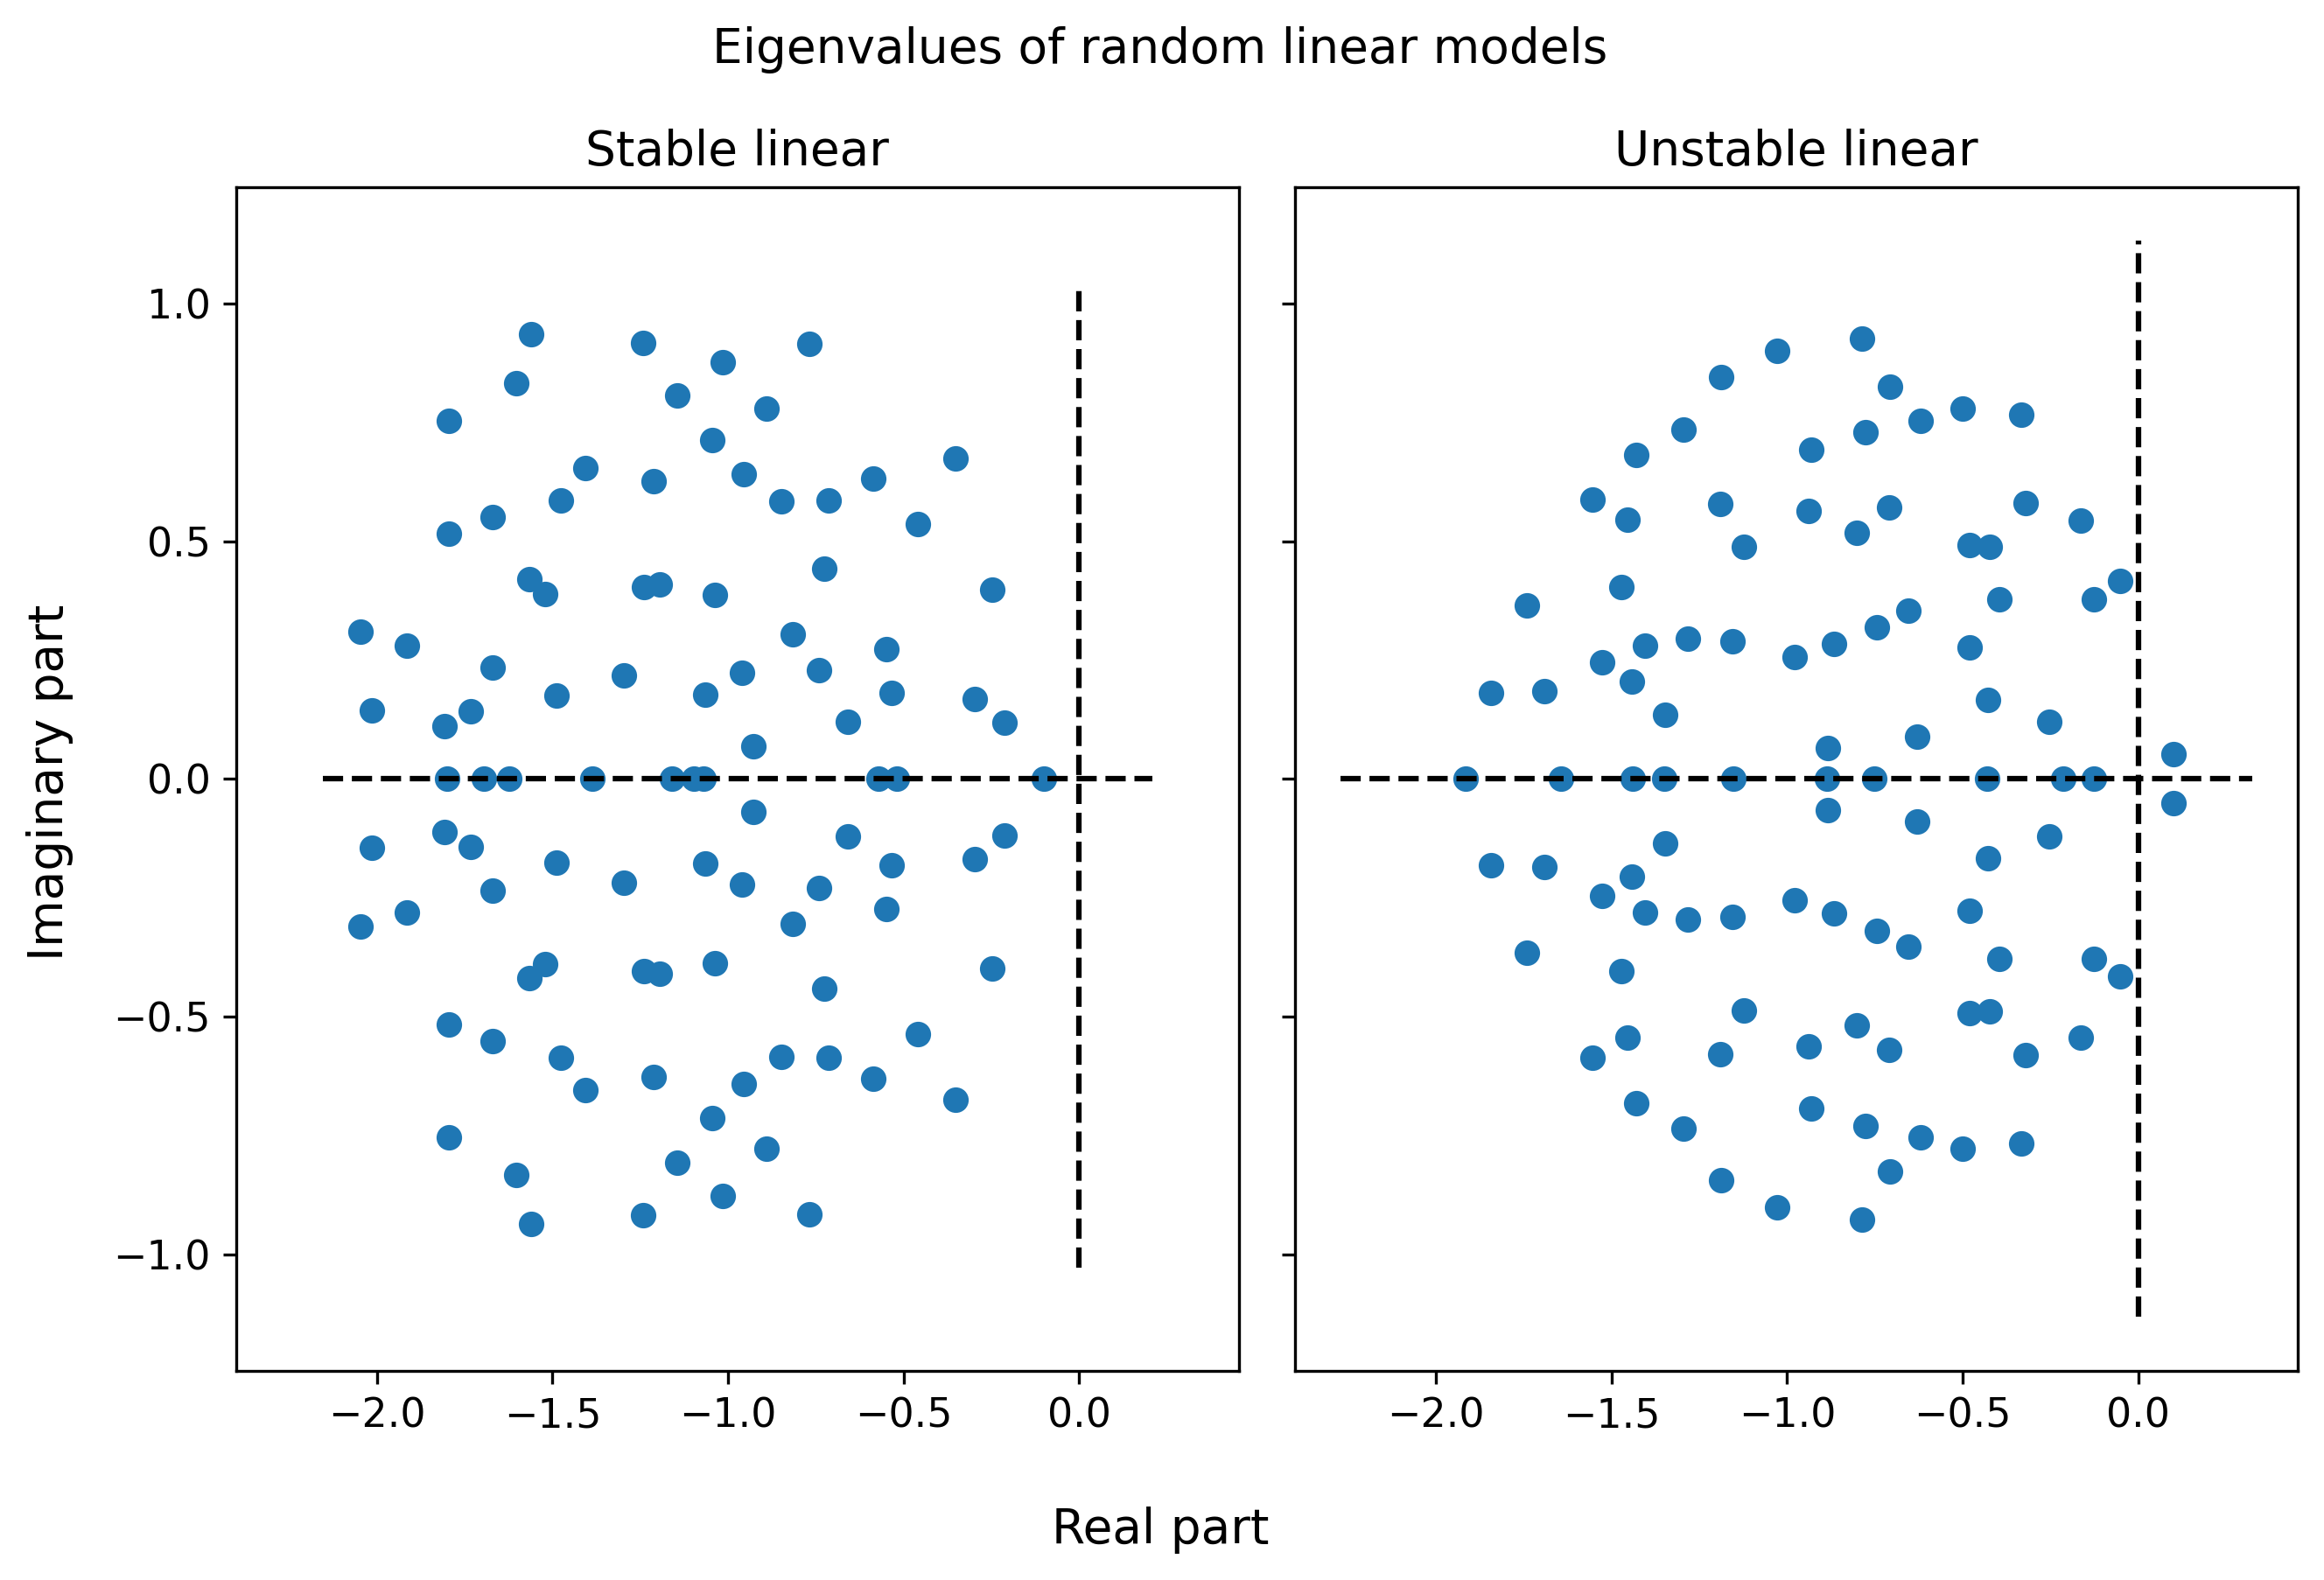

In [11]:
tmp_mdls = [get_random_linear(100, max_eig=-0.1, dvc=dvc), get_random_linear(100, max_eig=0.1, dvc=dvc)]
tmp_names = ["Stable linear", "Unstable linear"]
fig, axes = plt.subplots(1, 2, figsize=(9, 6), sharex=True, sharey=True)
for (i, ax) in enumerate(axes):
    eigvals = torch.linalg.eigvals(tmp_mdls[i].W - torch.diag(tmp_mdls[i].D)).cpu().detach().numpy()
    ax.scatter(eigvals.real, eigvals.imag)
    ax.set_title(tmp_names[i])
for ax in axes:
    ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color="black", linestyle="--")
    ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color="black", linestyle="--")

fig.supxlabel("Real part")
fig.supylabel("Imaginary part")
plt.suptitle("Eigenvalues of random linear models")
plt.tight_layout()
plt.savefig(os.path.join(figdir, "linear_example_eigvals.png"))
plt.show()

More experiments:

In [9]:
get_stable_linear = lambda N, **kwargs: get_random_linear(N, max_eig=-0.1, **kwargs)
get_unstable_linear = lambda N, **kwargs: get_random_linear(N, max_eig=0.1, **kwargs)

dfs = []
for sc in all_scaling:
    print(f"Getting error summary for stable linear models with scaling {sc}...")
    df_stable = get_error_summary(get_stable_linear, methods=methods,
                                  nMdlPerT=nMdlPerT, nSimPerMdl=nSimPerMdl, allT=allT, N=N, dvc=dvc,
                                  odeint_kwargs=odeint_kwargs, x1fun=x1_method, scaling=sc)
    df_stable['model'] = 'Stable linear'
    print(f"Getting error summary for unstable linear models with scaling {sc}...")
    df_unstable = get_error_summary(get_unstable_linear, methods=methods,
                                    nMdlPerT=nMdlPerT, nSimPerMdl=nSimPerMdl, allT=allT, N=N, dvc=dvc,
                                    odeint_kwargs=odeint_kwargs, x1fun=x1_method, scaling=sc)
    df_unstable['model'] = 'Unstable linear'
    dfs.append(df_stable)
    dfs.append(df_unstable)

df_linear = pd.concat(dfs, ignore_index=True)
df_linear.to_csv(os.path.join(datdir, "Linear_error.csv"), index=False)

Getting error summary for stable linear models with scaling 0.05...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/100655.tmpdir/ipykernel_2234/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for unstable linear models with scaling 0.05...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/100655.tmpdir/ipykernel_2234/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for stable linear models with scaling 0.1...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/100655.tmpdir/ipykernel_2234/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for unstable linear models with scaling 0.1...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/100655.tmpdir/ipykernel_2234/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for stable linear models with scaling 0.5...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/100655.tmpdir/ipykernel_2234/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for unstable linear models with scaling 0.5...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/100655.tmpdir/ipykernel_2234/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for stable linear models with scaling 1...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/100655.tmpdir/ipykernel_2234/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for unstable linear models with scaling 1...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/100655.tmpdir/ipykernel_2234/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Visualization on log-log scale:

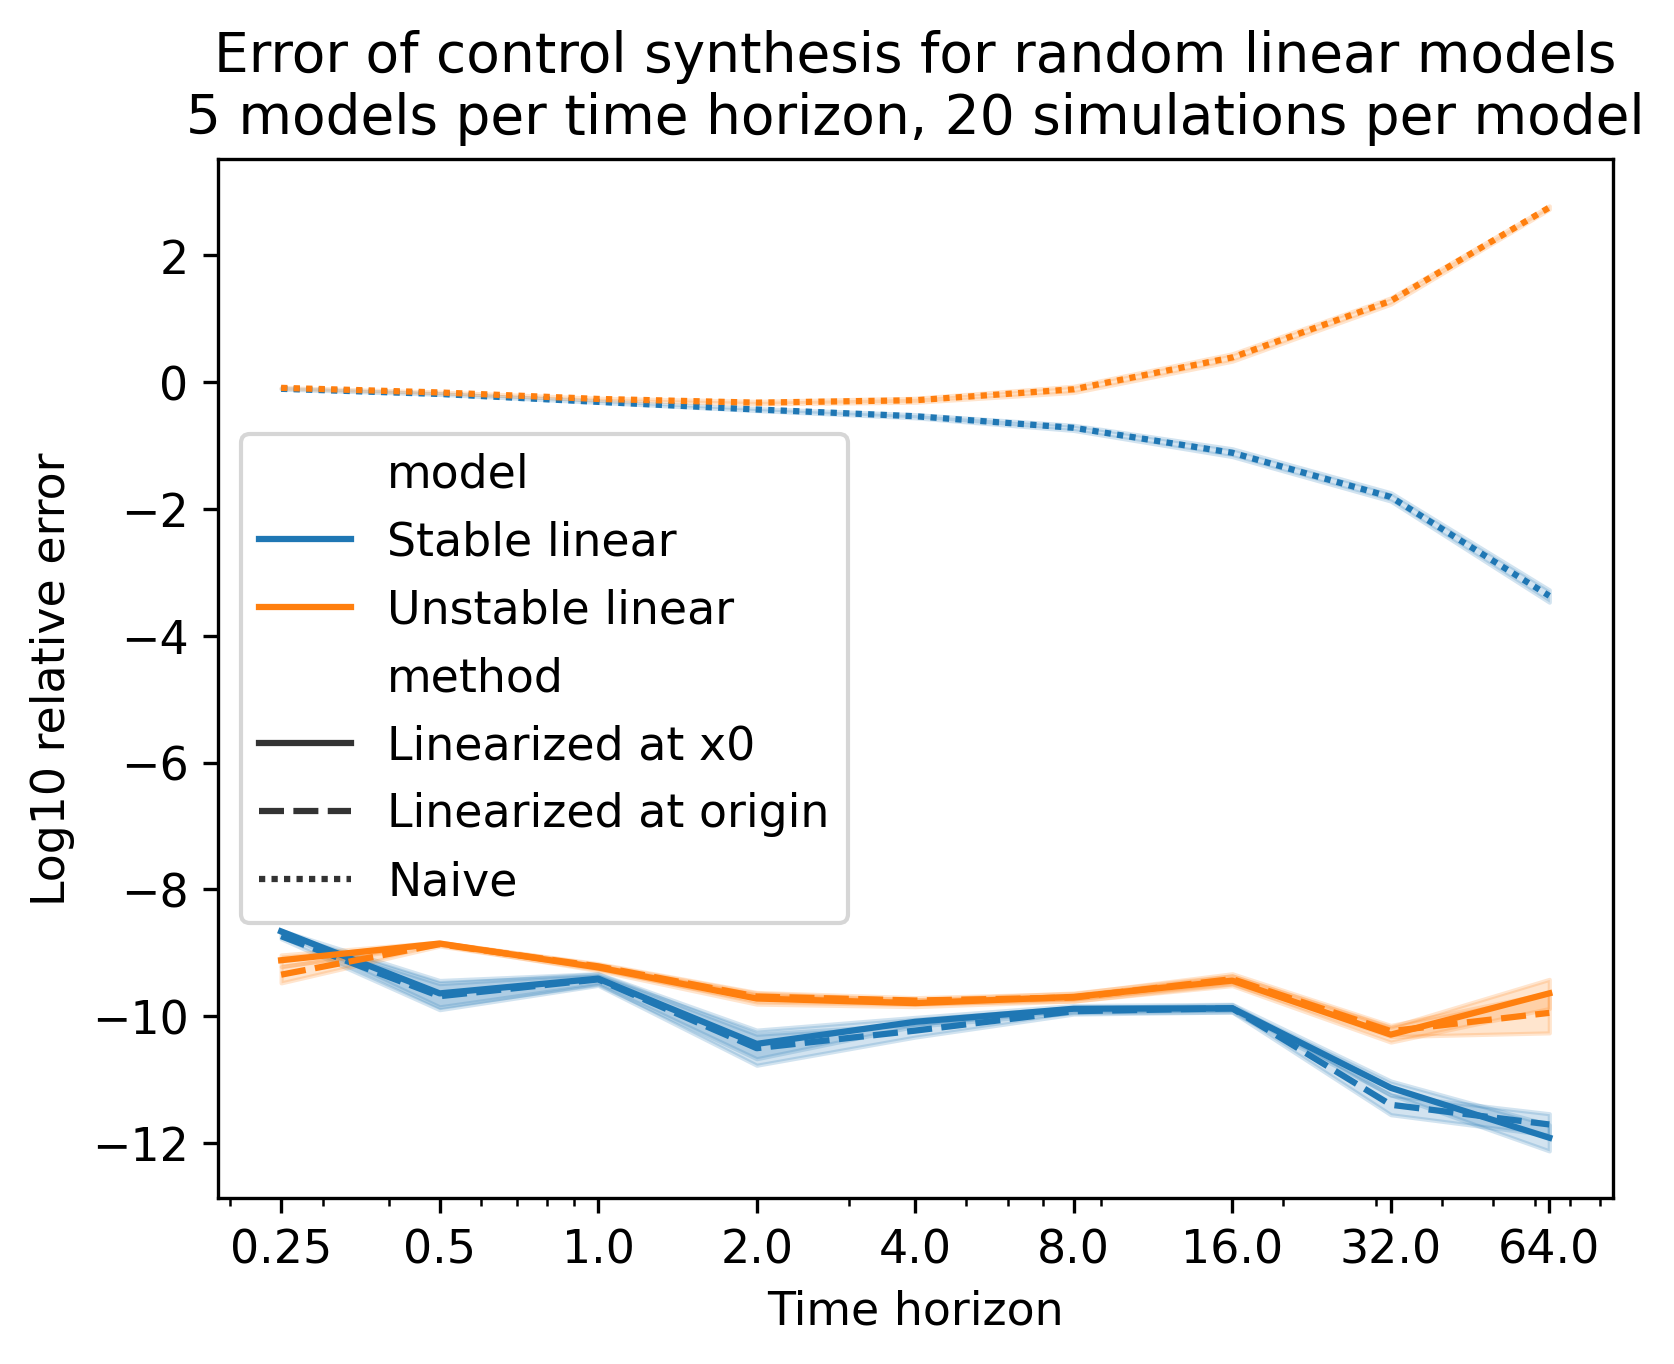

In [10]:
ax = vis_error(
    df_linear[
        (df_linear["method"].isin(["linearized", "linearized_origin", "naive"])) &
        (df_linear["scaling"] == 1)
    ]
)
ax.set_title(f"Error of control synthesis for random linear models\n{nMdlPerT} models per time horizon, {nSimPerMdl} simulations per model")
plt.savefig(os.path.join(figdir, "Linear_error.pdf"))

Note: errorbars indicate 95% confidence intervals computed over the 100 trials across 5 models.

### MINDy models

#### Show some examples

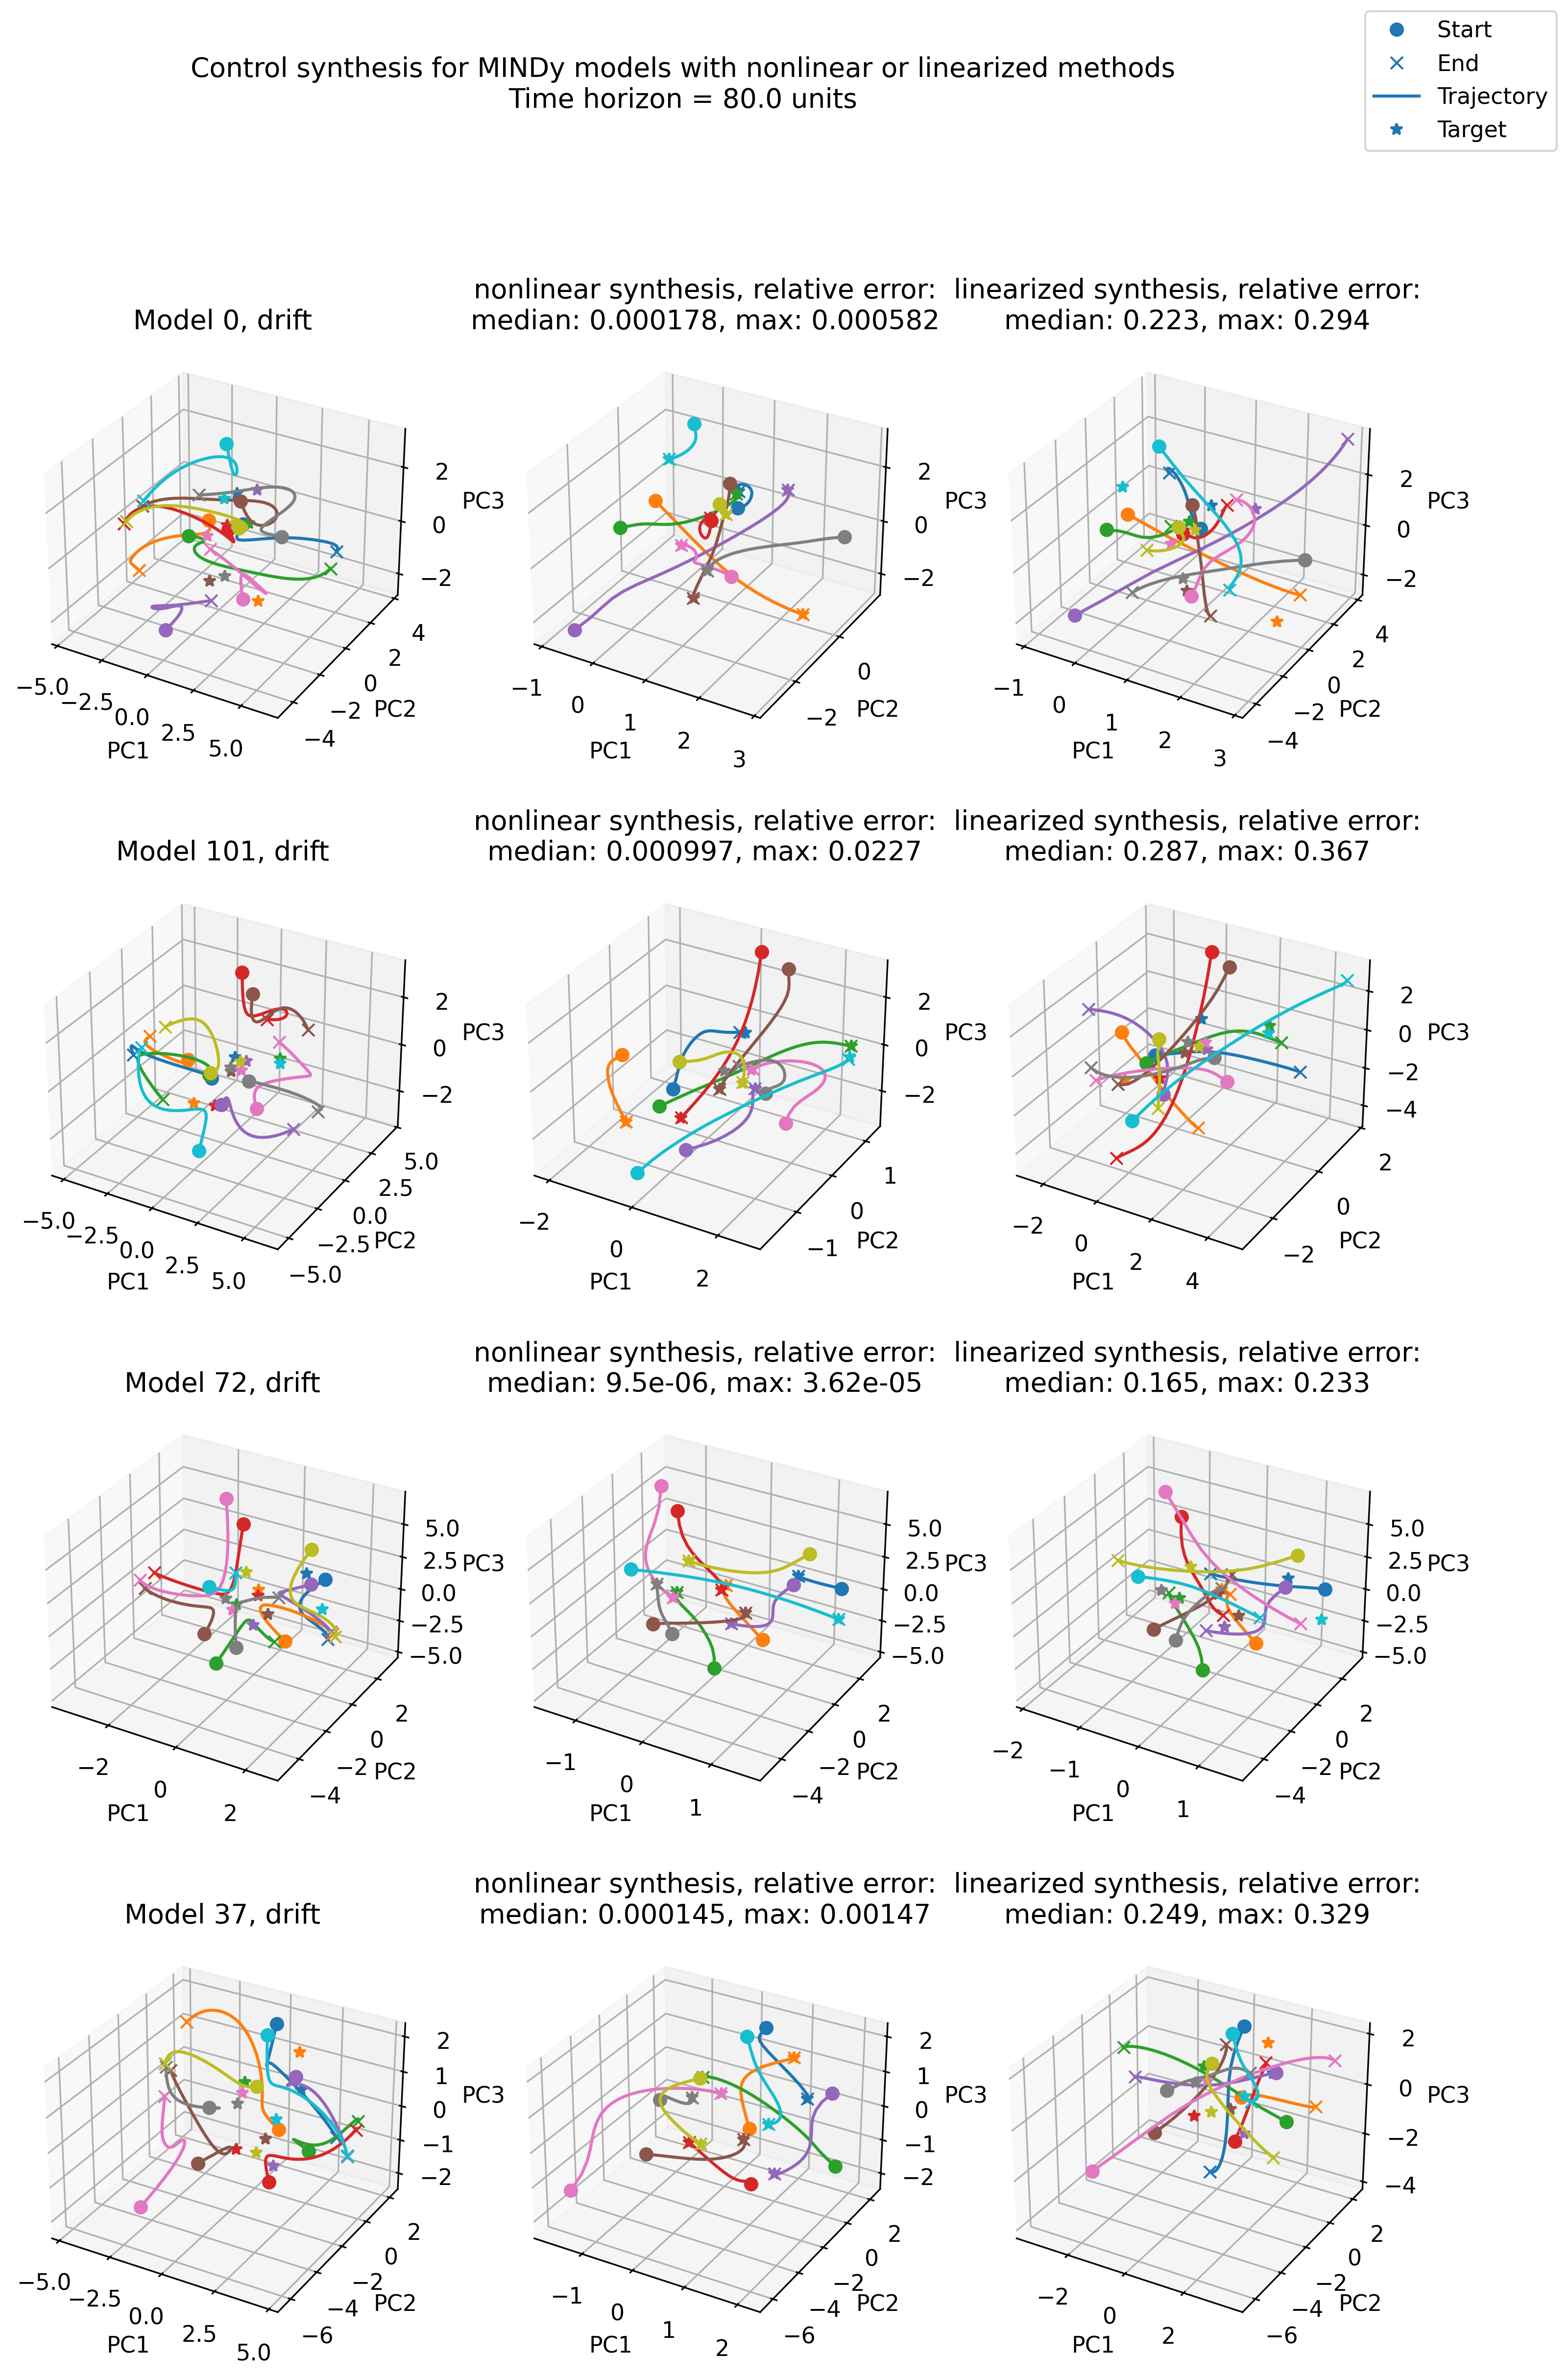

In [13]:
mindys = get_all_MINDys(dvc=dvc)

nTrials = 10  # Number of trials
T = 80.  # Time horizon

nMdls = 4  # Number of models to visualize
mdl_idx = np.random.choice(len(mindys), nMdls, replace=False)

fig, axes = plt.subplots(nMdls, 3, figsize=(12, 18), subplot_kw={"projection": "3d"})
for idx, axv in zip(mdl_idx, axes):
    x0, x1 = torch.randn(nTrials, N, device=dvc), torch.randn(nTrials, N, device=dvc)
    _, traj = get_traj(mindys[idx], x0, x1, T)
    vis_traj(traj, x1, axes=axv)
    title = axv[0].get_title()
    axv[0].set_title(f"Model {idx}, {title}")

fig.legend(axes[-1, -1].get_lines()[:4], ['Start', 'End', 'Trajectory', 'Target'])
fig.suptitle(f"Control synthesis for MINDy models with nonlinear or linearized methods\nTime horizon = {T:.1f} units")
plt.savefig(os.path.join(figdir, "MINDy_traj.png"))

We randomly selected four models and compare the endpoint error using three different inputs: zero input (drift), synthesis for nonlinear system, and the synthesis for the "linearized" system (if `x0` is not a fixed point, we counteract the drift using the input).

#### Summarizing plots for MINDy models

In [10]:
mindys = get_all_MINDys(dvc=dvc)

dfs = []
for sc in all_scaling:
    print(f"Getting error summary for MINDy models with scaling {sc}...")
    df_MINDy = get_error_summary(mindys, methods=methods, nMdlPerT=nMdlPerT,
                                 nSimPerMdl=nSimPerMdl, allT=allT, N=N, dvc=dvc,
                                 odeint_kwargs=odeint_kwargs, x1fun=x1_method, scaling=sc)
    df_MINDy['model'] = 'MINDy'
    dfs.append(df_MINDy)

df_MINDy = pd.concat(dfs, ignore_index=True)
df_MINDy.to_csv(os.path.join(datdir, "MINDy_error.csv"), index=False)

Getting error summary for MINDy models with scaling 0.05...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for MINDy models with scaling 0.1...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for MINDy models with scaling 0.5...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for MINDy models with scaling 1...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Visualizing the results for all models:

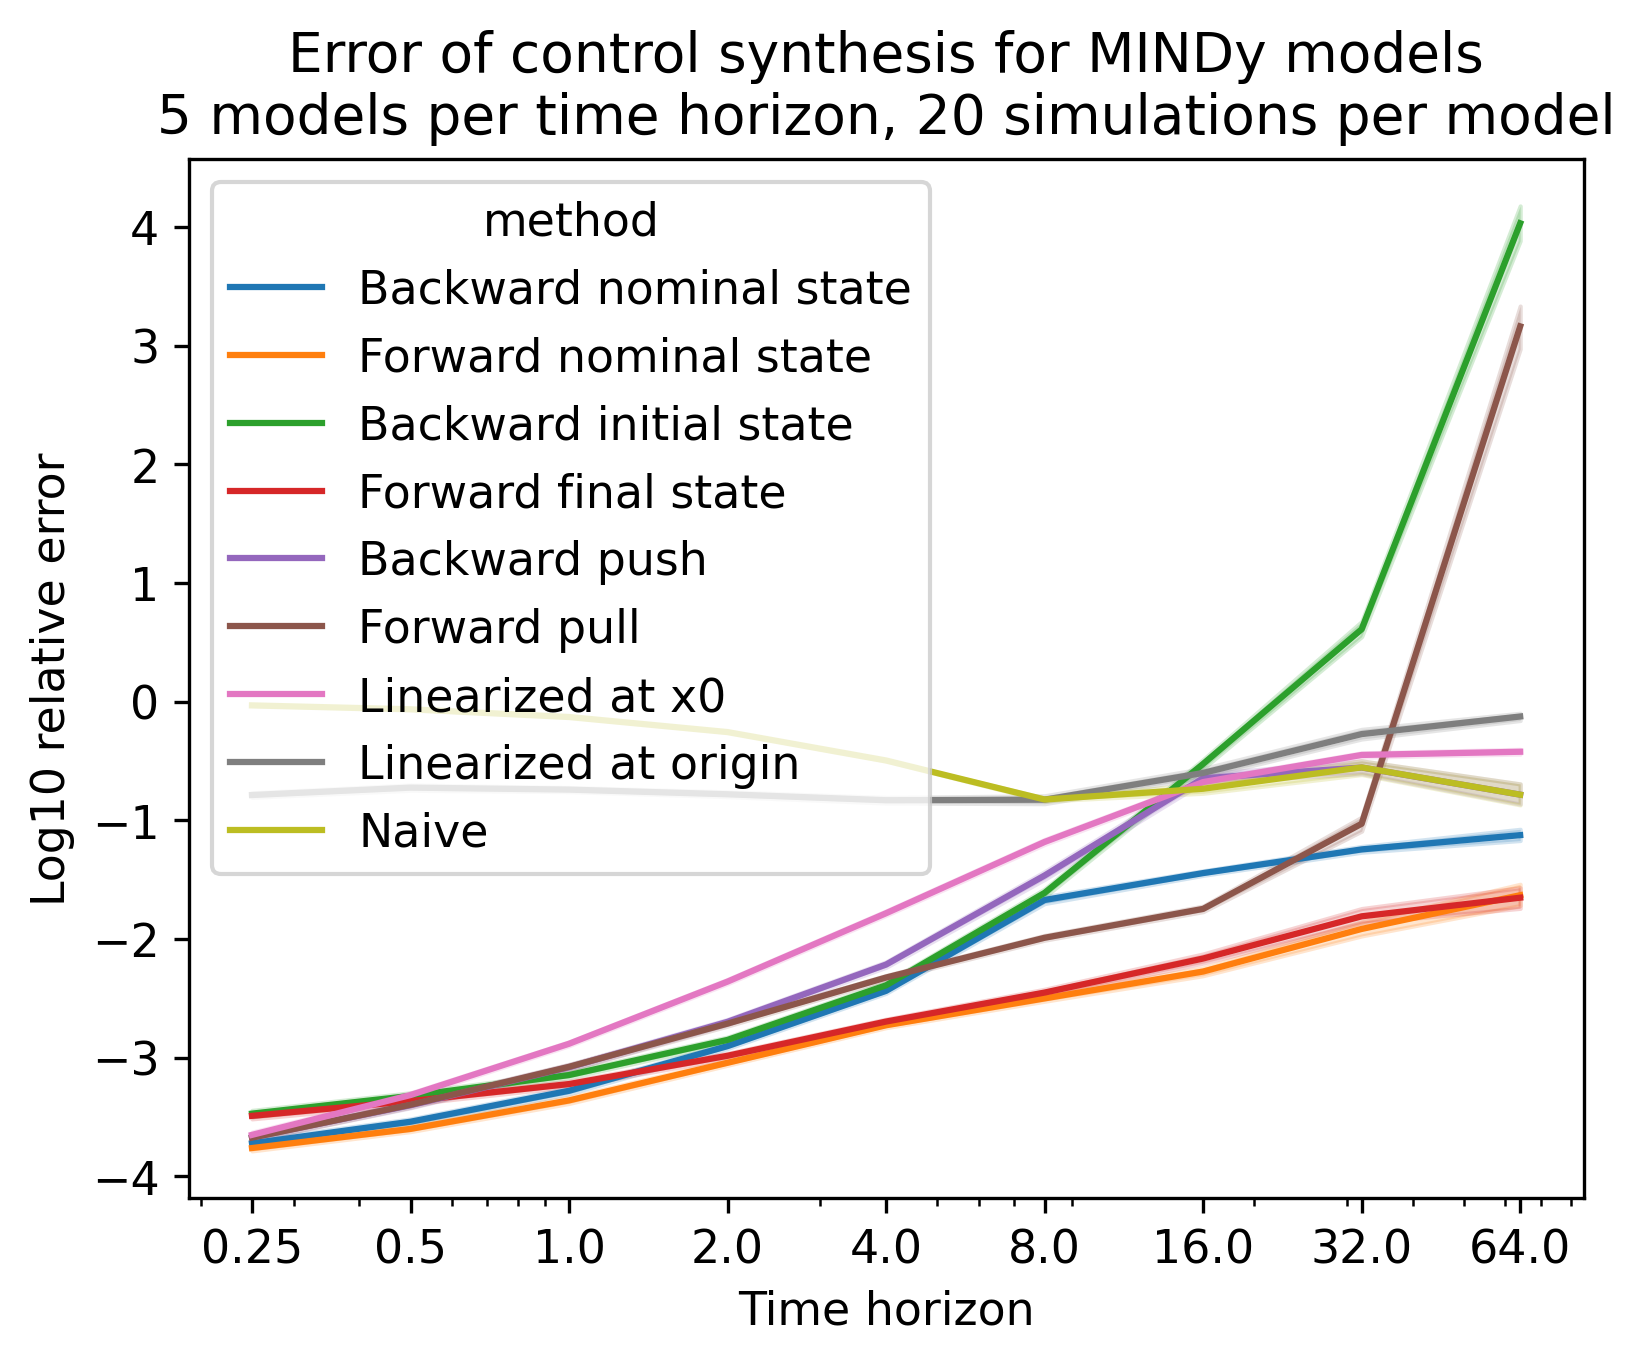

In [16]:
ax = vis_error(df_MINDy[df_MINDy["scaling"] == 0.05])
ax.set_title(f"Error of control synthesis for MINDy models\n{nMdlPerT} models per time horizon, {nSimPerMdl} simulations per model")
plt.savefig(os.path.join(figdir, "MINDy_error.pdf"))

### Random tanh RNNs

We generate random RNNs with tanh activation functions according to [(Schuessler et al., 2020)](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.013111). The eigenspectrum of the Jacobian of the model at the origin will contain a bulk centered at (-1, 0) with a radius of `g` and several outliers, where `g` is a scaling factor of the random part of connectivity and the outliers are determined by the low-rank component.

We have three types of RNNs:

1. An RNN with `g = 0.9` ("edge of chaos") and low-rank component rank `K = 1`. No correlation between the low-rank component and the random part. This is commonly used in the literature. The dynamics are usually monostable.
2. Similar to the first one, but the low-rank component is correlated with the random part, leading to an eigenvalue outlier that usually makes the dynamics bistable.
3. An RNN with `g = 0.5` and no low-rank component. We found that this type of RNNs has a spectral norm slightly smaller than 1, thus satisfying the spectral norm condition $|\!|\!|W|\!|\!| < \lambda_{\min}(D)$. This can improve the performance of forward synthesis. Particularly, the initial value problem error is reduced.

Example eigenspectrum and drift dynamics were shown below:

In [9]:
# Functions to generate monostable/bistable/smallnorm models
get_monostable = lambda N, **kwargs: get_RNN(N, K=1, g=0.9, theta_i=[], **kwargs)
get_bistable = lambda N, **kwargs: get_RNN(N, K=1, g=0.9, theta_i=[1.2], **kwargs)
get_smallnorm = lambda N, **kwargs: get_RNN(N, K=0, g=0.5, theta_i=[], **kwargs)

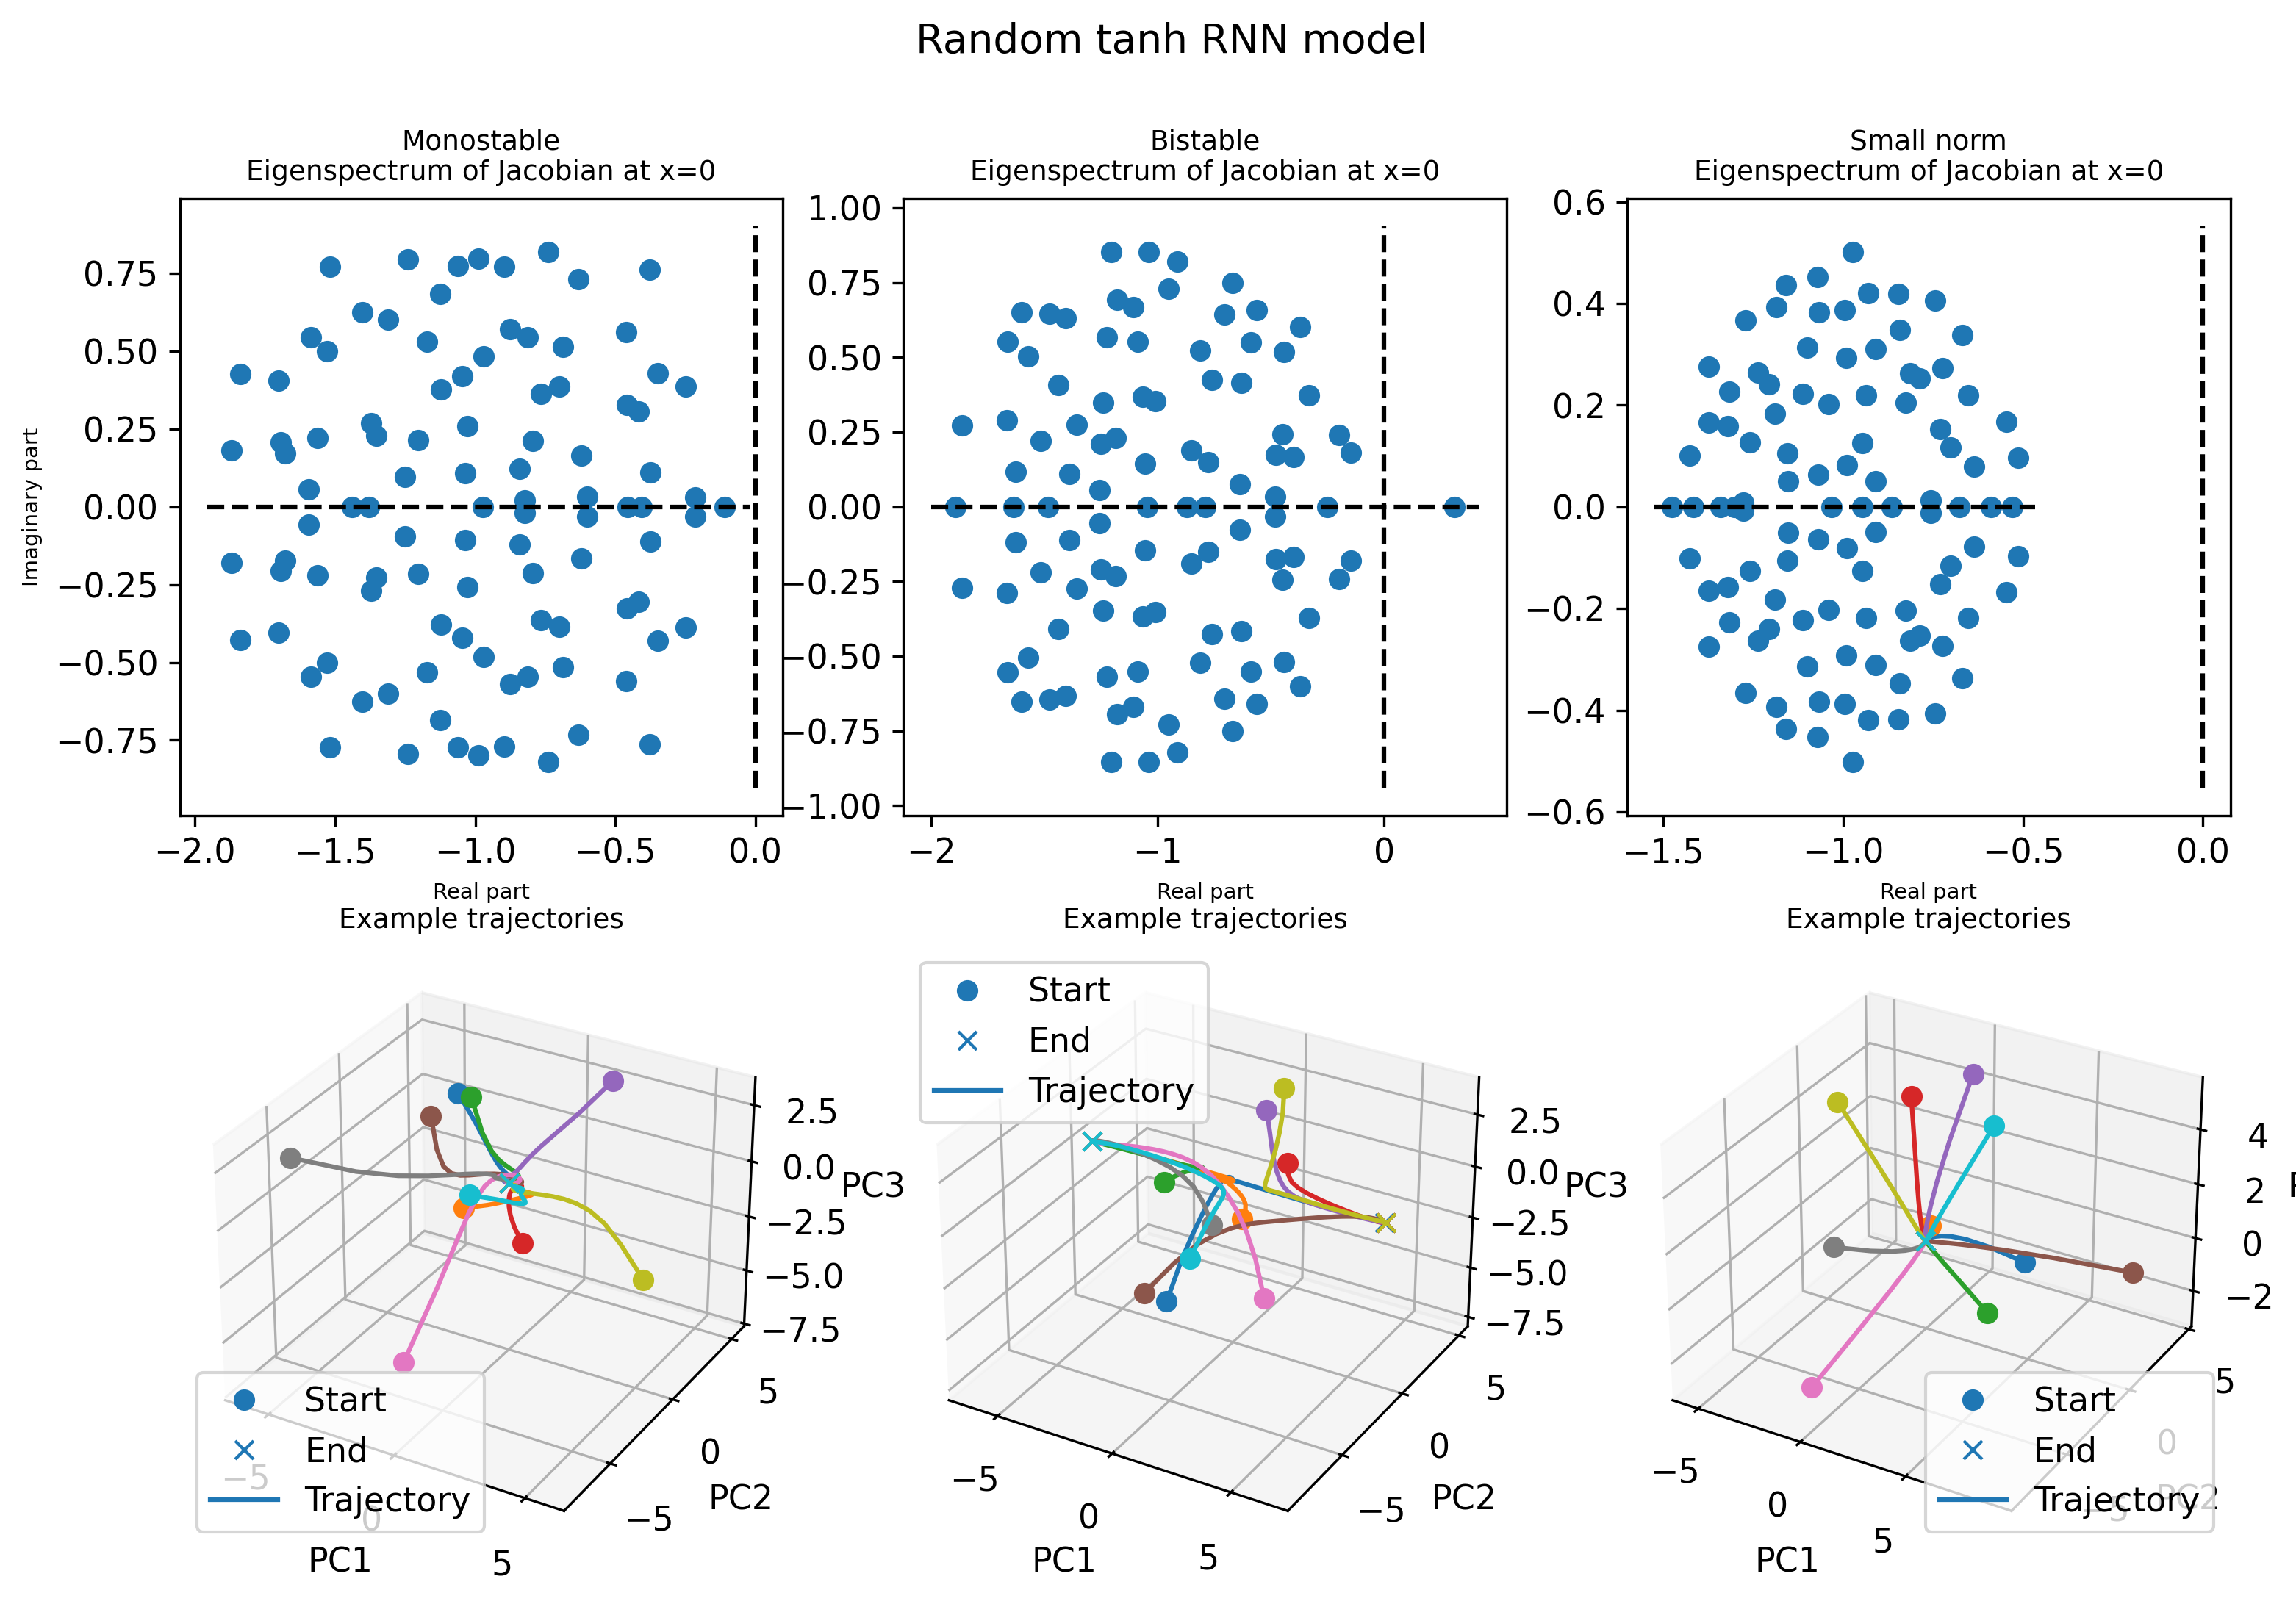

In [13]:
tmpN = 100
mdl1 = get_monostable(tmpN, dvc=dvc)
mdl2 = get_bistable(tmpN, dvc=dvc)
mdl3 = get_smallnorm(tmpN, dvc=dvc)
titles = ["Monostable", "Bistable", "Small norm"]
x0 = torch.randn(10, tmpN, device=dvc)

fig = plt.figure(figsize=(12, 8))

for (i, mdl) in enumerate([mdl1, mdl2, mdl3]):

    sims = odeint(mdl, x0, torch.linspace(0, 50, 100, device=dvc))
    J = jacobian(lambda x: mdl(0., x), torch.zeros(tmpN, device=dvc))
    eigvals = torch.linalg.eigvals(J).cpu().detach().numpy()
    ax = fig.add_subplot(2, 3, i + 1)
    ax.scatter(eigvals.real, eigvals.imag)
    ax.set_title(titles[i] + "\nEigenspectrum of Jacobian at x=0", fontsize=9)
    ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color="black", linestyle="--")
    ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color="black", linestyle="--")
    ax.set_xlabel("Real part", fontsize=7)
    if i == 0:
        ax.set_ylabel("Imaginary part", fontsize=7)

    ax = fig.add_subplot(2, 3, i + 4, projection="3d")
    PlotTraj(sims, ax=ax)
    ax.set_title("Example trajectories", fontsize=9)

# plt.tight_layout()
plt.suptitle("Random tanh RNN model")
plt.savefig(os.path.join(figdir, "Tanh_example.png"))

More experiments:

In [17]:
dfs = []
for sc in all_scaling:
    print(f"Getting error summary for monostable tanh RNN with scaling {sc}...")
    df_mono = get_error_summary(get_monostable, methods=methods, nMdlPerT=nMdlPerT,
                                nSimPerMdl=nSimPerMdl, allT=allT, N=N, dvc=dvc,
                                odeint_kwargs=odeint_kwargs, x1fun=x1_method, scaling=sc)
    df_mono['model'] = 'Monostable tanh RNN'
    print(f"Getting error summary for bistable tanh RNN with scaling {sc}...")
    df_bi = get_error_summary(get_bistable, methods=methods, nMdlPerT=nMdlPerT,
                              nSimPerMdl=nSimPerMdl, allT=allT, N=N, dvc=dvc,
                              odeint_kwargs=odeint_kwargs, x1fun=x1_method, scaling=sc)
    df_bi['model'] = 'Bistable tanh RNN'
    print(f"Getting error summary for small norm tanh RNN with scaling {sc}...")
    df_smallnorm = get_error_summary(get_smallnorm, methods=methods, nMdlPerT=nMdlPerT,
                                     nSimPerMdl=nSimPerMdl, allT=allT, N=N, dvc=dvc,
                                     odeint_kwargs=odeint_kwargs, x1fun=x1_method, scaling=sc)
    df_smallnorm['model'] = 'Small norm tanh RNN'
    dfs.append(df_mono)
    dfs.append(df_bi)
    dfs.append(df_smallnorm)

df_tanh = pd.concat(dfs, ignore_index=True)
df_tanh.to_csv(os.path.join(datdir, "Tanh_error.csv"), index=False)

Getting error summary for monostable tanh RNN with scaling 0.05...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for bistable tanh RNN with scaling 0.05...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for small norm tanh RNN with scaling 0.05...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for monostable tanh RNN with scaling 0.1...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for bistable tanh RNN with scaling 0.1...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for small norm tanh RNN with scaling 0.1...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for monostable tanh RNN with scaling 0.5...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for bistable tanh RNN with scaling 0.5...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for small norm tanh RNN with scaling 0.5...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for monostable tanh RNN with scaling 1...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for bistable tanh RNN with scaling 1...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Getting error summary for small norm tanh RNN with scaling 1...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0
T=32.0
T=64.0


/tmp/80455.tmpdir/ipykernel_16965/2685444355.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


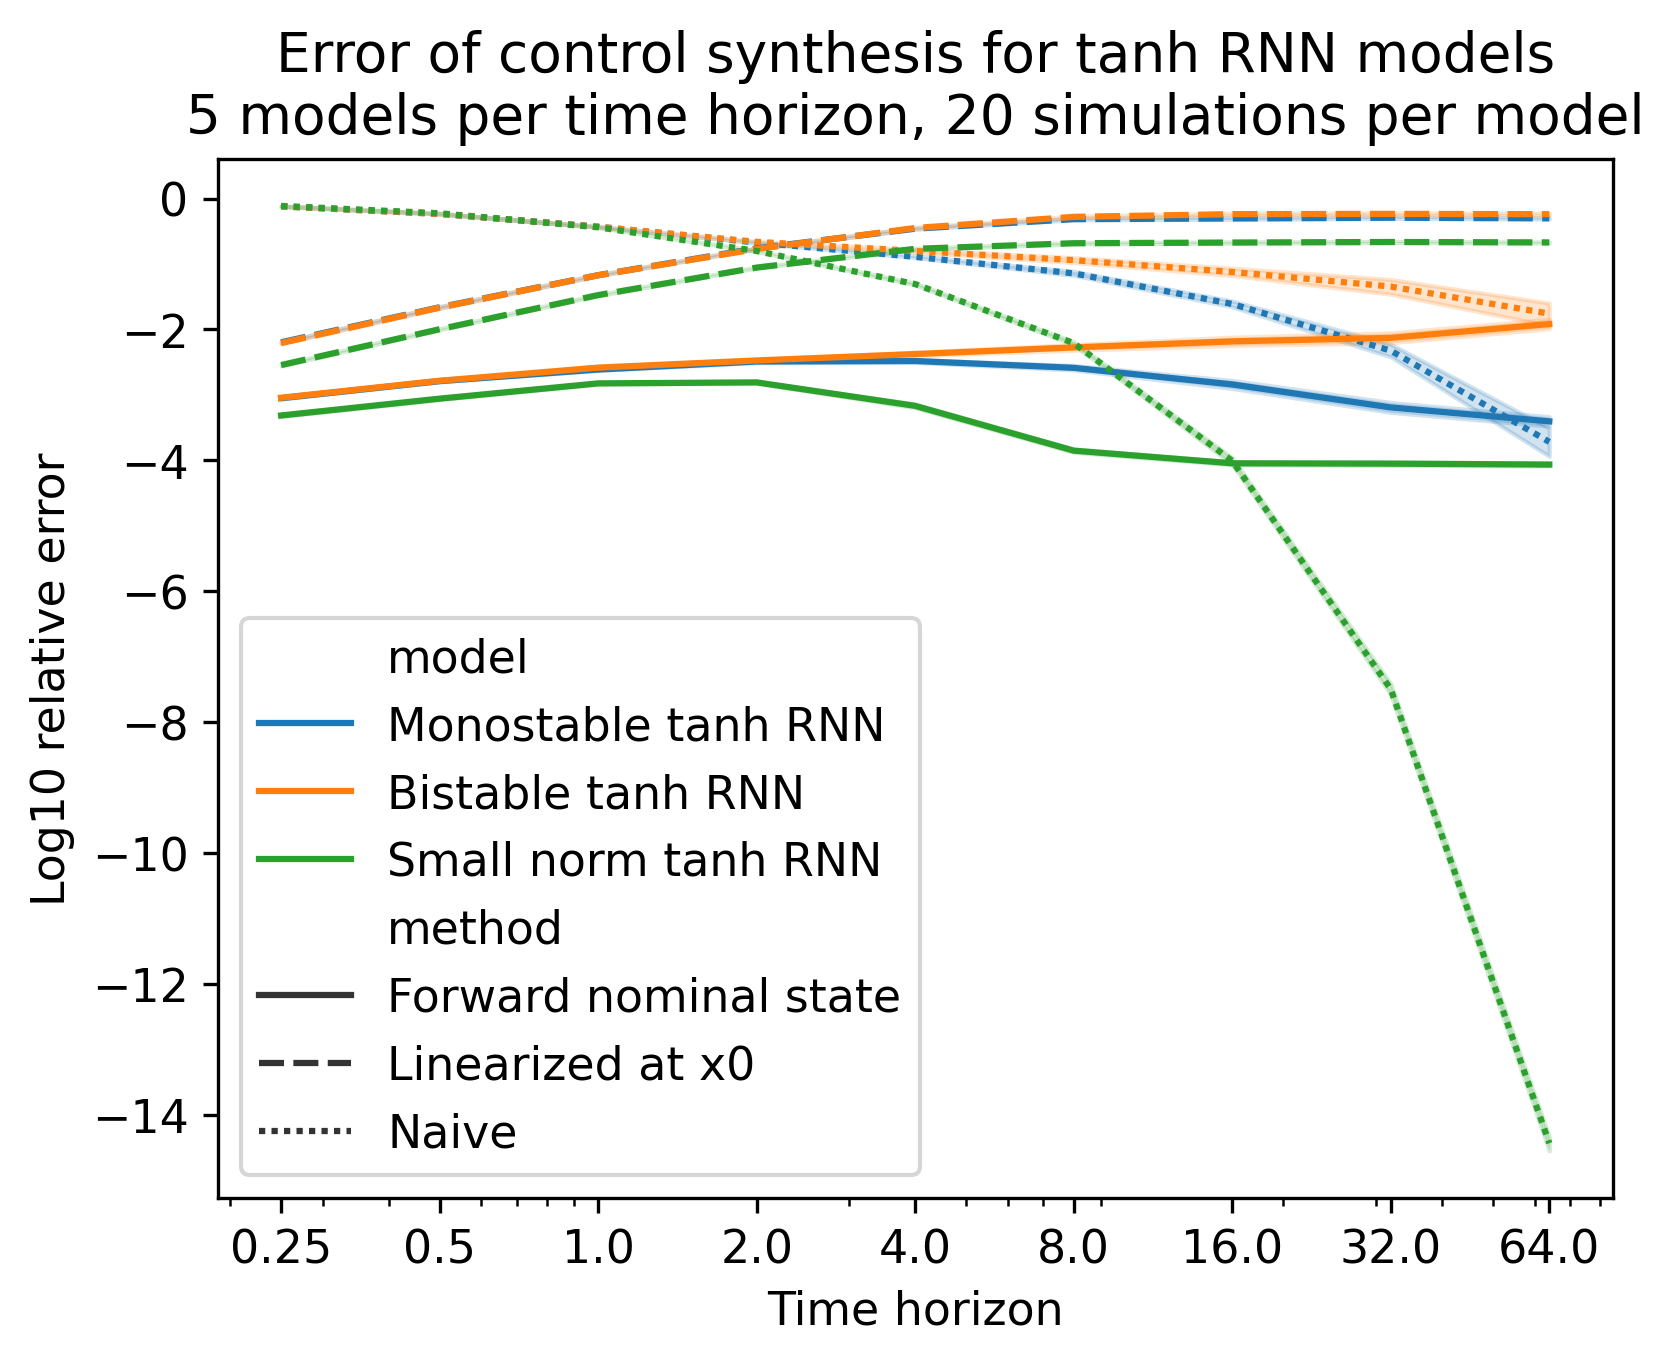

In [18]:
ax = vis_error(df_tanh[
    (df_tanh["method"].isin(["forward_nominal_state", "linearized", "naive"])) &
    (df_tanh["scaling"] == 0.05)
])
ax.set_title(f"Error of control synthesis for tanh RNN models\n{nMdlPerT} models per time horizon, {nSimPerMdl} simulations per model")
plt.savefig(os.path.join(figdir, "Tanh_error.pdf"))

#### Exceptional cases

It's worth noting that for RNNs with more complicated dynamics (e.g., if the low rank component satisfies $n^{\top}Jm > 0$), sometimes the endpoint error is larger. Here is an example:

In [ ]:
mdl = get_RNN(100, K=1, theta_i=[1.2, 1], dvc=dvc)
x0 = torch.randn(30, 100, device=dvc)
x1 = torch.randn(30, 100, device=dvc)
T = 30.
I = synthesize(mdl, x0, x1, T)[0]

sims = odeint(mdl, x0, torch.linspace(0, T, 100, device=dvc))

c_mdl = ControlledMdl(mdl, I)
c_sims = odeint(c_mdl, x0, torch.linspace(0, T, 100, device=dvc))
xt = c_sims[-1]
err = torch.norm(xt - x1, dim=-1) / torch.norm(x1, dim=-1)
err = torch.log10(err).cpu().detach().numpy()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 3, 1, projection="3d")
PlotTraj(sims, ax=ax)
ax.set_title("Drift")
ax = fig.add_subplot(1, 3, 2, projection="3d")
PlotTraj(c_sims, x1, sims, ax=ax)
ax.set_title("Controlled")
ax = fig.add_subplot(1, 3, 3)
sns.histplot(err, ax=ax)
ax.set_title("Log10 relative error")

plt.suptitle("Control synthesis for more complex tanh RNN model")
plt.savefig(os.path.join(figdir, "Tanh_exceptional.png"))

## Summary of endpoint error results

In [11]:
dfs = []
fs = ["Linear_error.csv", "MINDy_error.csv", "Tanh_error.csv"]
for f in fs:
    df = pd.read_csv(os.path.join(datdir, f))
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

print(df)
df.to_csv(os.path.join(datdir, "error_summary.csv"), index=False)

            T                  method  model_idx  experiment_idx  \
0        0.25  backward_nominal_state          1               1   
1        0.25  backward_nominal_state          1               2   
2        0.25  backward_nominal_state          1               3   
3        0.25  backward_nominal_state          1               4   
4        0.25  backward_nominal_state          1               5   
...       ...                     ...        ...             ...   
194395  64.00                   naive          5              16   
194396  64.00                   naive          5              17   
194397  64.00                   naive          5              18   
194398  64.00                   naive          5              19   
194399  64.00                   naive          5              20   

               error      Mcond  ivp_error  scaling           x1_method  \
0       3.776892e-09  44.953864        NaN     0.05  drift_perturbation   
1       3.623671e-09  44.953864  

## Experiments with underactuated systems

In this section, we will use input matrix `B` that has rank smaller than the state space. We will not use MINDy models here, as the dimensions in MINDy models are not interchangeable. Instead, we plan to use 128-dimensional random tanh RNNs that either satisfy the spectral norm condition (`smallnorm`) or not (`bistable`). We will consider time horizons up to 16 for simplicity, and we will consider input dimension $k$ from 1 to 128.

### (Approximately) reachable cases

In this case we choose random $x^0$, but select $x^1$ such that the synthesized input $I$ is in the range of $B$. In principle, such $x^1$ should be approximately reachable by $u = B^{+}I$. We will only use the forward nominal state synthesis here.

The way we construct $x^1$ given $x^0$, $B = [e_{i_{1}}, e_{i_{2}}, \dots, e_{i_{k}}]$ (where $e_{i}$ is the $i$-th canonical vector in $\mathbb{R}^{d}$) and $T$ is the following:

1. Compute the matrix $\mathcal A_T(x^0)=[e^{TDN(\Phi_T(x^0))}-\text{Id}]^{-1}DN(\Phi_T(x^0))$.
2. Let $M\in\mathbb{R}^{(d - k)\times d}$ be the matrix consisting of the rows of $\mathcal{A}_{T}(x^{0})$ where the corresponding rows of $B$ are zeros.
3. Compute the full QR decomposition of $M^{\top}$, i.e., $M^{\top} = Q R$ with $Q\in\mathbb{R}^{d\times d}$ and $R\in\mathbb{R}^{d\times (d - k)}$, with the last $k$ rows of $R$ being zero.
4. The null space of $M$ is spanned by the last $k$ columns of $Q$, denoted as $Q_{2}$
5. Then $v$ is given by $v = Q_{2}\xi$ where $\xi$ is a random vector in $\mathbb{R}^{k}$.
6. Set $x^{1} = \Phi_{T}(x^{0}) + v$ and run the synthesis.

This is implemented in the `'approx_reachable'` option of the `get_x1` function.

Experiment setup:

In [ ]:
allT = [2. ** e for e in range(-2, 5)]
allK = [1, 16, 32, 64, 96, 120, 126, 128]
all_scaling = [0.1, 1]
x1_method = "approx_reachable"  # Use the approximation of reachable set
nMdlPerT, nSimPerMdl, N = 10, 30, 128
methods = ["forward_nominal_state", "linearized"]
odeint_kwargs = {"atol": 1e-14, "rtol": 1e-13, "method": "dopri8"}

Get the models and input matrices ahead of time as we need to compare within the same model:

In [11]:
mdls_smallnorm = [get_smallnorm(N, dvc=dvc) for _ in range(nMdlPerT)]

In [ ]:
dfs = []
for k in allK:
    Bs = [torch.eye(N, device=dvc, dtype=default_dtype)[:, :k] for _ in range(nMdlPerT)]
    for sc in all_scaling:
        print(f"K={k}, scaling={sc}...")
        print(f"Smallnorm tanh RNN with One-hot input matrix...")
        df = get_error_summary(mdls_smallnorm, Bfun=Bs, methods=methods, x1fun=x1_method, scaling=sc,
            nMdlPerT=nMdlPerT, nSimPerMdl=nSimPerMdl, shuffle_mdls=False,
            allT=allT, N=N, dvc=dvc, odeint_kwargs=odeint_kwargs)
        df['model'] = "Small norm tanh RNN"
        df['K'] = k
        df['input_type'] = "One-hot"
        dfs.append(df)

df_NonIdInput = pd.concat(dfs, ignore_index=True)
df_NonIdInput.to_csv(os.path.join(datdir, "NonIdInput_approx_reachable_error.csv"), index=False)

K=1, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=1, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=16, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=16, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=32, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=32, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=64, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=64, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=96, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=96, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=120, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=120, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=126, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=126, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=128, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=128, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/43544.tmpdir/ipykernel_45186/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


### Numerically reachable cases

In this case, we choose $x^{1}$ by selecting some random $u$ and numerically integrating the model to get $x^{1}$.

This is implemented in the `'numeric_reachable'` option of the `get_x1` function.

Run experiments:

In [ ]:
allT = [2. ** e for e in range(-2, 4)]
allK = [1, 16, 32, 64, 96, 120, 126, 128]
all_scaling = [0.1, 1]
x1_method = "numeric_reachable"  # Use the numerically obtained reachable set
nMdlPerT, nSimPerMdl, N = 10, 30, 128
methods = ["forward_nominal_state", "linearized"]
odeint_kwargs = {"atol": 1e-14, "rtol": 1e-13, "method": "dopri8"}

Get the models and input matrices ahead of time as we need to compare within the same model:

In [26]:
mdls_smallnorm = [get_smallnorm(N, dvc=dvc) for _ in range(nMdlPerT)]

In [ ]:
dfs = []
for k in allK:
    Bs = [torch.eye(N, device=dvc, dtype=default_dtype)[:, :k] for _ in range(nMdlPerT)]
    for sc in all_scaling:
        print(f"K={k}, scaling={sc}...")
        print(f"Smallnorm tanh RNN with One-hot input matrix...")
        df = get_error_summary(mdls_smallnorm, Bfun=Bs, methods=methods, x1fun=x1_method, scaling=sc,
            nMdlPerT=nMdlPerT, nSimPerMdl=nSimPerMdl, shuffle_mdls=False,
            allT=allT, N=N, dvc=dvc, odeint_kwargs=odeint_kwargs)
        df['model'] = "Small norm tanh RNN"
        df['K'] = k
        df['input_type'] = "One-hot"
        df['scaling'] = sc
        dfs.append(df)

df_NonIdInput = pd.concat(dfs, ignore_index=True)
df_NonIdInput.to_csv(os.path.join(datdir, "NonIdInput_numeric_reachable_error.csv"), index=False)

K=1, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=1, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=16, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=16, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=32, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=32, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=64, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=64, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=96, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=96, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=120, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=120, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=126, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=126, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=128, scaling=0.1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=128, scaling=1...
Smallnorm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0


/tmp/43544.tmpdir/ipykernel_29498/3935382331.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


### Not necessarily reachable cases

In this case we choose random $x^0$ and $x^1$ for the synthesis. Because $B$ is not full rank, there is no guarantee that the two-point boundary value problem is solvable. We want to use this experiment to show how big the reachable set is, and how accurate can the synthesis be when the endpoint is not necessarily reachable.

In [ ]:
allT = [2. ** e for e in range(-2, 5)]
allK = [1, 16, 32, 64, 96, 120, 126, 128]
x1_method = "random"  # Use random target state
nMdlPerT, nSimPerMdl, N = 10, 100, 128
methods = ["backward_nominal_state", "forward_nominal_state", "linearized", "naive"]
odeint_kwargs = {"atol": 1e-14, "rtol": 1e-13, "method": "dopri8"}

Get the models and input matrices ahead of time as we need to compare within the same model:

In [13]:
mdls_bistable = [get_bistable(N, dvc=dvc) for _ in range(nMdlPerT)]
mdls_smallnorm = [get_smallnorm(N, dvc=dvc) for _ in range(nMdlPerT)]

Experiments:

In [ ]:
dfs = []
for k in allK:
    print(f"K={k}...")
    Bs1 = [torch.eye(N, device=dvc, dtype=default_dtype)[:, :k] for _ in range(nMdlPerT)]
    Bs2 = [torch.randn(N, k, device=dvc, dtype=default_dtype) for _ in range(nMdlPerT)]
    for (Bs, input_type) in zip([Bs1, Bs2], ['One-hot', 'Random']):
        for (mdl_fun, mdl_name) in zip([mdls_bistable, mdls_smallnorm], ["Bistable tanh RNN", "Small norm tanh RNN"]):
            print(f"{mdl_name} with {input_type} input matrix...")
            df = get_error_summary(mdl_fun, Bfun=Bs, methods=methods, x1fun=x1_method, scaling=1.,
                nMdlPerT=nMdlPerT, nSimPerMdl=nSimPerMdl, shuffle_mdls=False,
                allT=allT, N=N, dvc=dvc, odeint_kwargs=odeint_kwargs)
            df['model'] = mdl_name
            df['K'] = k
            df['input_type'] = input_type
            dfs.append(df)

df_NonIdInput = pd.concat(dfs, ignore_index=True)
df_NonIdInput.to_csv(os.path.join(datdir, "NonIdInput_error.csv"), index=False)

K=1...
Bistable tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Bistable tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=16...
Bistable tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Bistable tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=32...
Bistable tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Bistable tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=64...
Bistable tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Bistable tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=96...
Bistable tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Bistable tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=120...
Bistable tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Bistable tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=126...
Bistable tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Bistable tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


K=128...
Bistable tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with One-hot input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Bistable tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


Small norm tanh RNN with Random input matrix...
T=0.25
T=0.5
T=1.0
T=2.0
T=4.0
T=8.0
T=16.0


/tmp/886699.tmpdir/ipykernel_2068/2312508772.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, ignore_index=True)


## Run time

We benchmarked the run time for linear and tanh RNNs respectively, and analyze how it changes with the number of neurons `N`, the time horizon `T`, and the number of samples `n`.

In [7]:
from timeit import timeit

### Dependence on the number of neurons `N`

In [8]:
allN = [32, 64, 128, 256, 512]
T = 10.
n = 1
n_rep = 5

times = [pd.DataFrame(columns=["N", "time", "Model"])]
for N in allN:
    for _ in range(n_rep):
        print(f"N = {N}, Rep {_}")
        mdl = get_RNN(N, dvc=dvc)
        x0 = torch.randn(n, N, device=dvc)
        x1 = torch.randn(n, N, device=dvc)
        time = timeit(lambda: synthesize(mdl, x0, x1, T, method="forward_nominal_state"), number=1)
        times.append(pd.DataFrame({"N": N, "time": time, "Model": "RNN"}, index=[0]))

        mdl = get_random_linear(N, dvc=dvc)
        time = timeit(lambda: synthesize(mdl, x0, x1, T, method="linearized"), number=1)
        times.append(pd.DataFrame({"N": N, "time": time, "Model": "Linear"}, index=[0]))

df = pd.concat(times, ignore_index=True)

N = 32, Rep 0
N = 32, Rep 1
N = 32, Rep 2
N = 32, Rep 3
N = 32, Rep 4
N = 64, Rep 0
N = 64, Rep 1
N = 64, Rep 2
N = 64, Rep 3
N = 64, Rep 4
N = 128, Rep 0
N = 128, Rep 1
N = 128, Rep 2
N = 128, Rep 3
N = 128, Rep 4
N = 256, Rep 0
N = 256, Rep 1
N = 256, Rep 2
N = 256, Rep 3
N = 256, Rep 4
N = 512, Rep 0
N = 512, Rep 1
N = 512, Rep 2
N = 512, Rep 3
N = 512, Rep 4


/tmp/43544.tmpdir/ipykernel_413/3729580834.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(times, ignore_index=True)


In [9]:
df.to_csv(os.path.join(datdir, "synthesis_time_N.csv"))

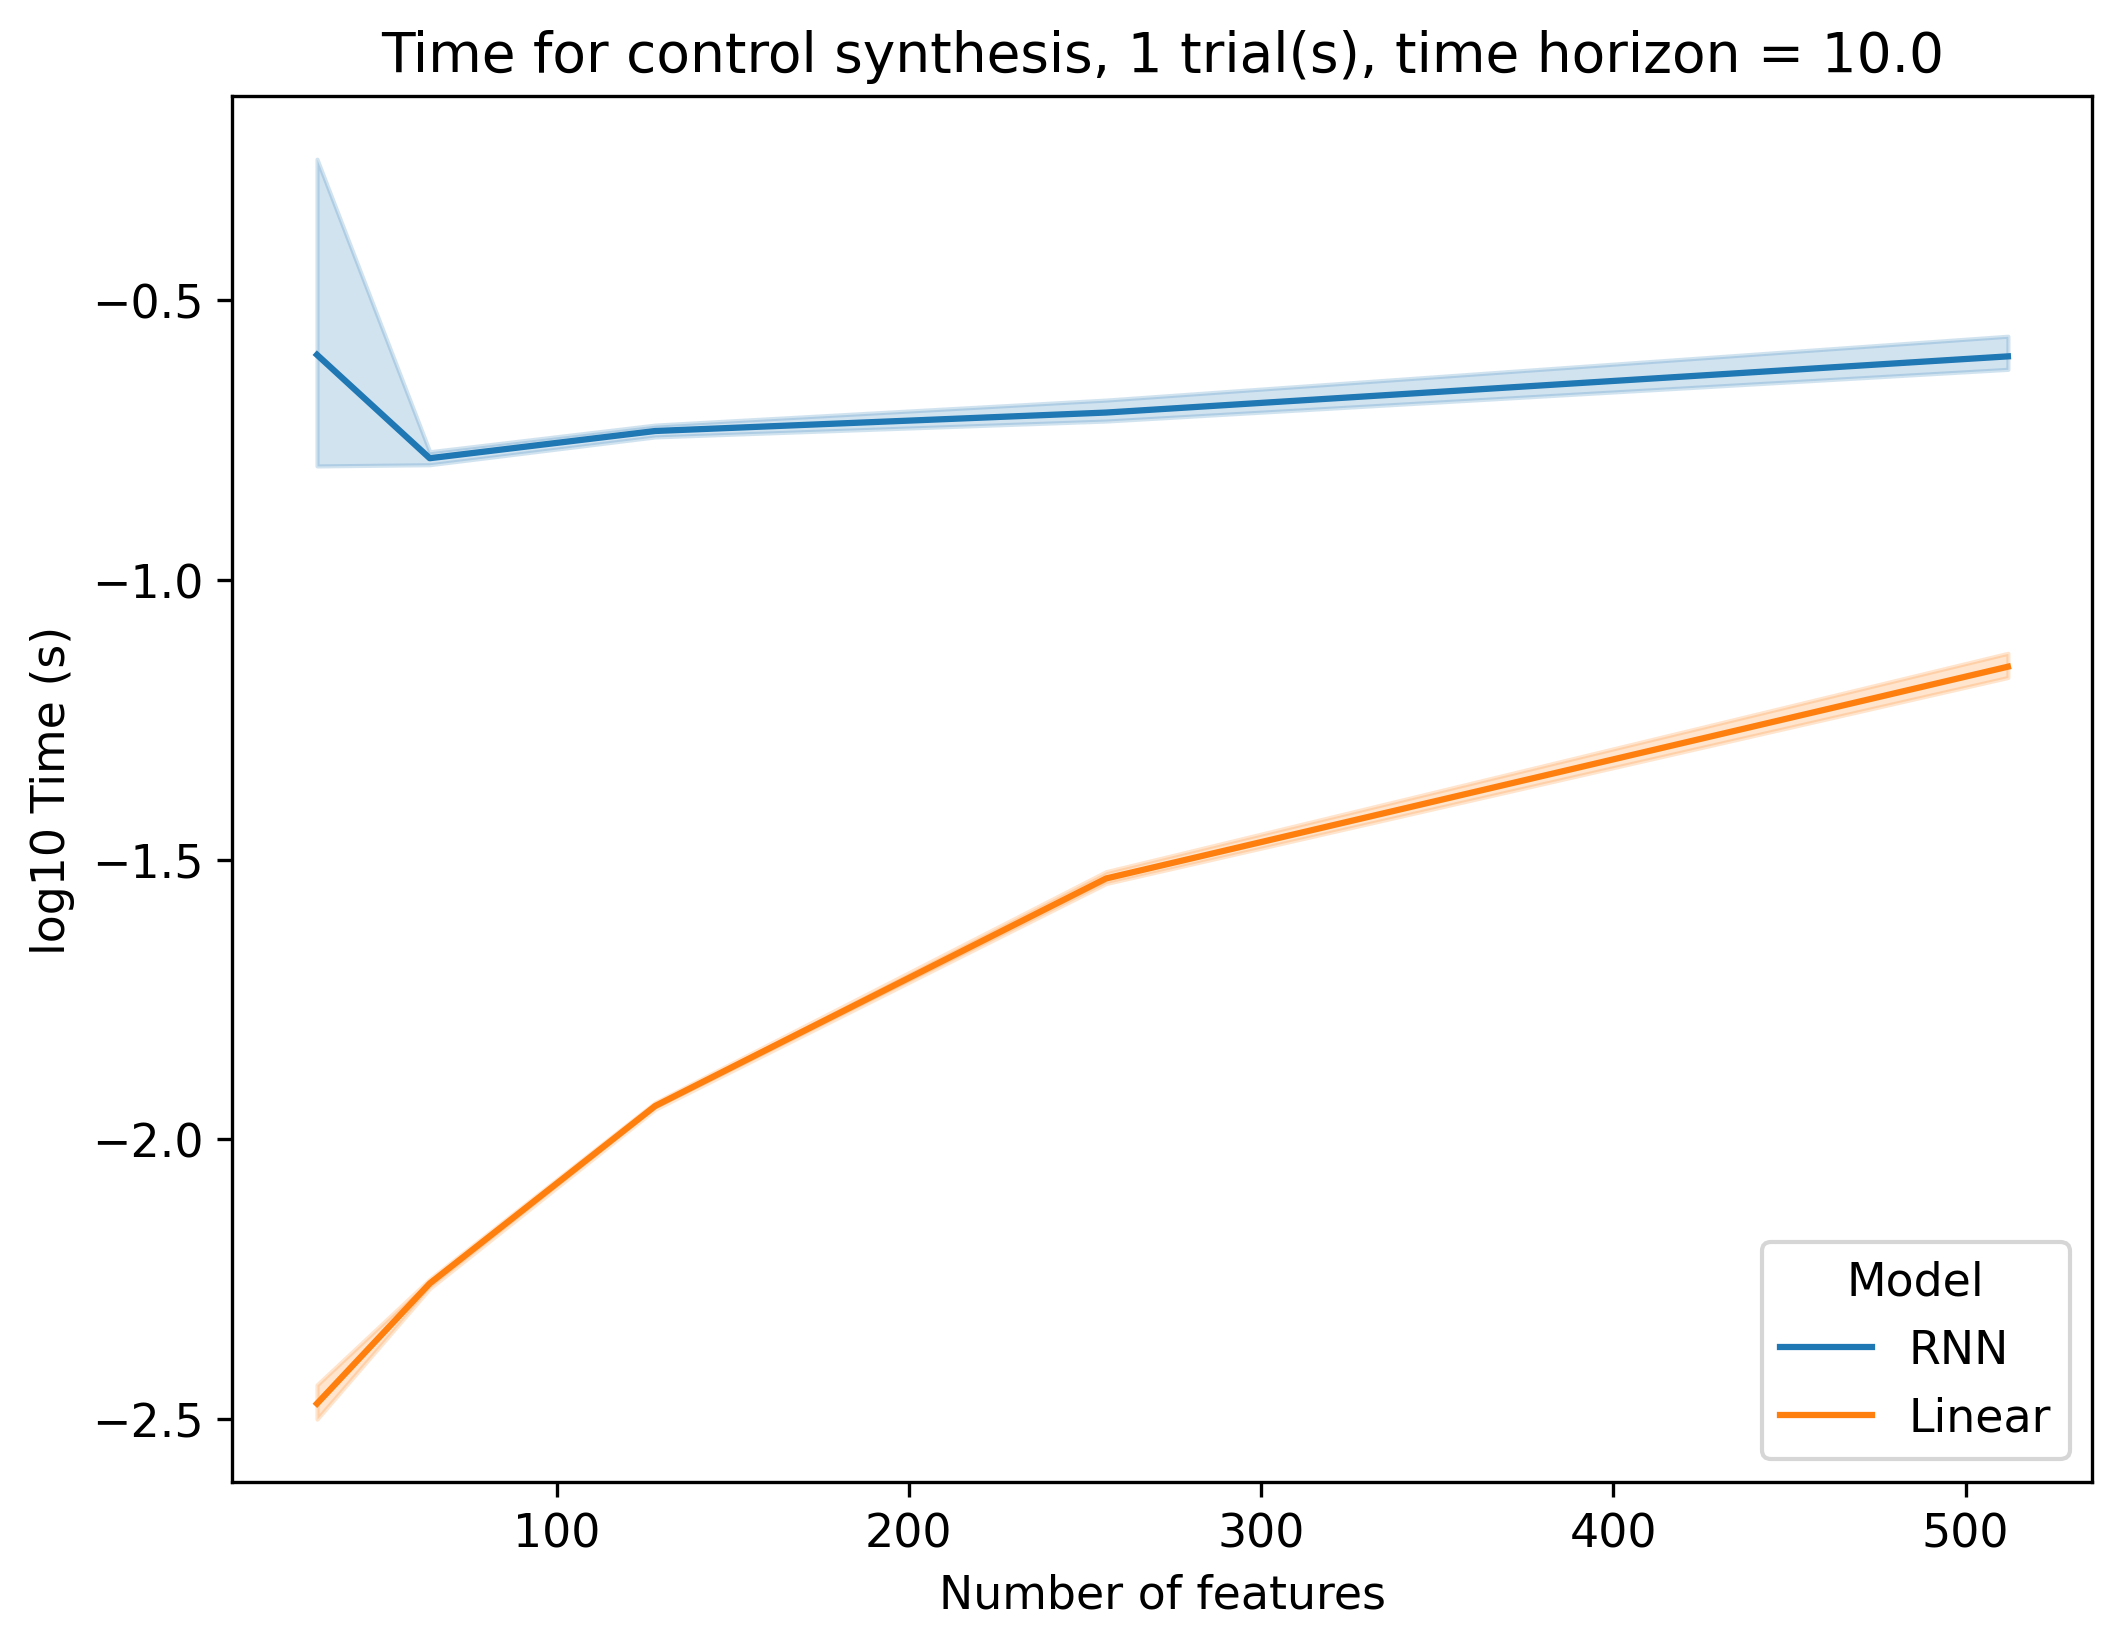

In [10]:
df['log_time'] = np.log10(df['time'])
sns.lineplot(data=df, x="N", y="log_time", hue="Model")
plt.xlabel("Number of features")
plt.ylabel("log10 Time (s)")
plt.title(f"Time for control synthesis, {n} trial(s), time horizon = {T}")
plt.savefig(os.path.join(figdir, "time_comparison_dim.pdf"))

### Dependence on the number of trials `n`

In [11]:
alln = [1, 4, 16, 64, 256, 1024]
T = 10.
N = 100
n_rep = 5

times = [pd.DataFrame(columns=["n", "time", "Model"])]
for n in alln:
    for _ in range(n_rep):
        print(f"n = {n}, Rep {_}")
        mdl = get_RNN(N, dvc=dvc)
        x0 = torch.randn(n, N, device=dvc)
        x1 = torch.randn(n, N, device=dvc)
        time = timeit(lambda: synthesize(mdl, x0, x1, T, method="forward_nominal_state"), number=1)
        times.append(pd.DataFrame({"n": n, "time": time, "Model": "RNN"}, index=[0]))

        mdl = get_random_linear(N, dvc=dvc)
        time = timeit(lambda: synthesize(mdl, x0, x1, T, method="linearized"), number=1)
        times.append(pd.DataFrame({"n": n, "time": time, "Model": "Linear"}, index=[0]))

df = pd.concat(times, ignore_index=True)

n = 1, Rep 0
n = 1, Rep 1
n = 1, Rep 2
n = 1, Rep 3
n = 1, Rep 4
n = 4, Rep 0
n = 4, Rep 1
n = 4, Rep 2
n = 4, Rep 3
n = 4, Rep 4
n = 16, Rep 0
n = 16, Rep 1
n = 16, Rep 2
n = 16, Rep 3
n = 16, Rep 4
n = 64, Rep 0
n = 64, Rep 1
n = 64, Rep 2
n = 64, Rep 3
n = 64, Rep 4
n = 256, Rep 0
n = 256, Rep 1
n = 256, Rep 2
n = 256, Rep 3
n = 256, Rep 4
n = 1024, Rep 0
n = 1024, Rep 1
n = 1024, Rep 2
n = 1024, Rep 3
n = 1024, Rep 4


/tmp/43544.tmpdir/ipykernel_413/1724024879.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(times, ignore_index=True)


In [12]:
df.to_csv(os.path.join(datdir, "synthesis_time_nTrials.csv"))

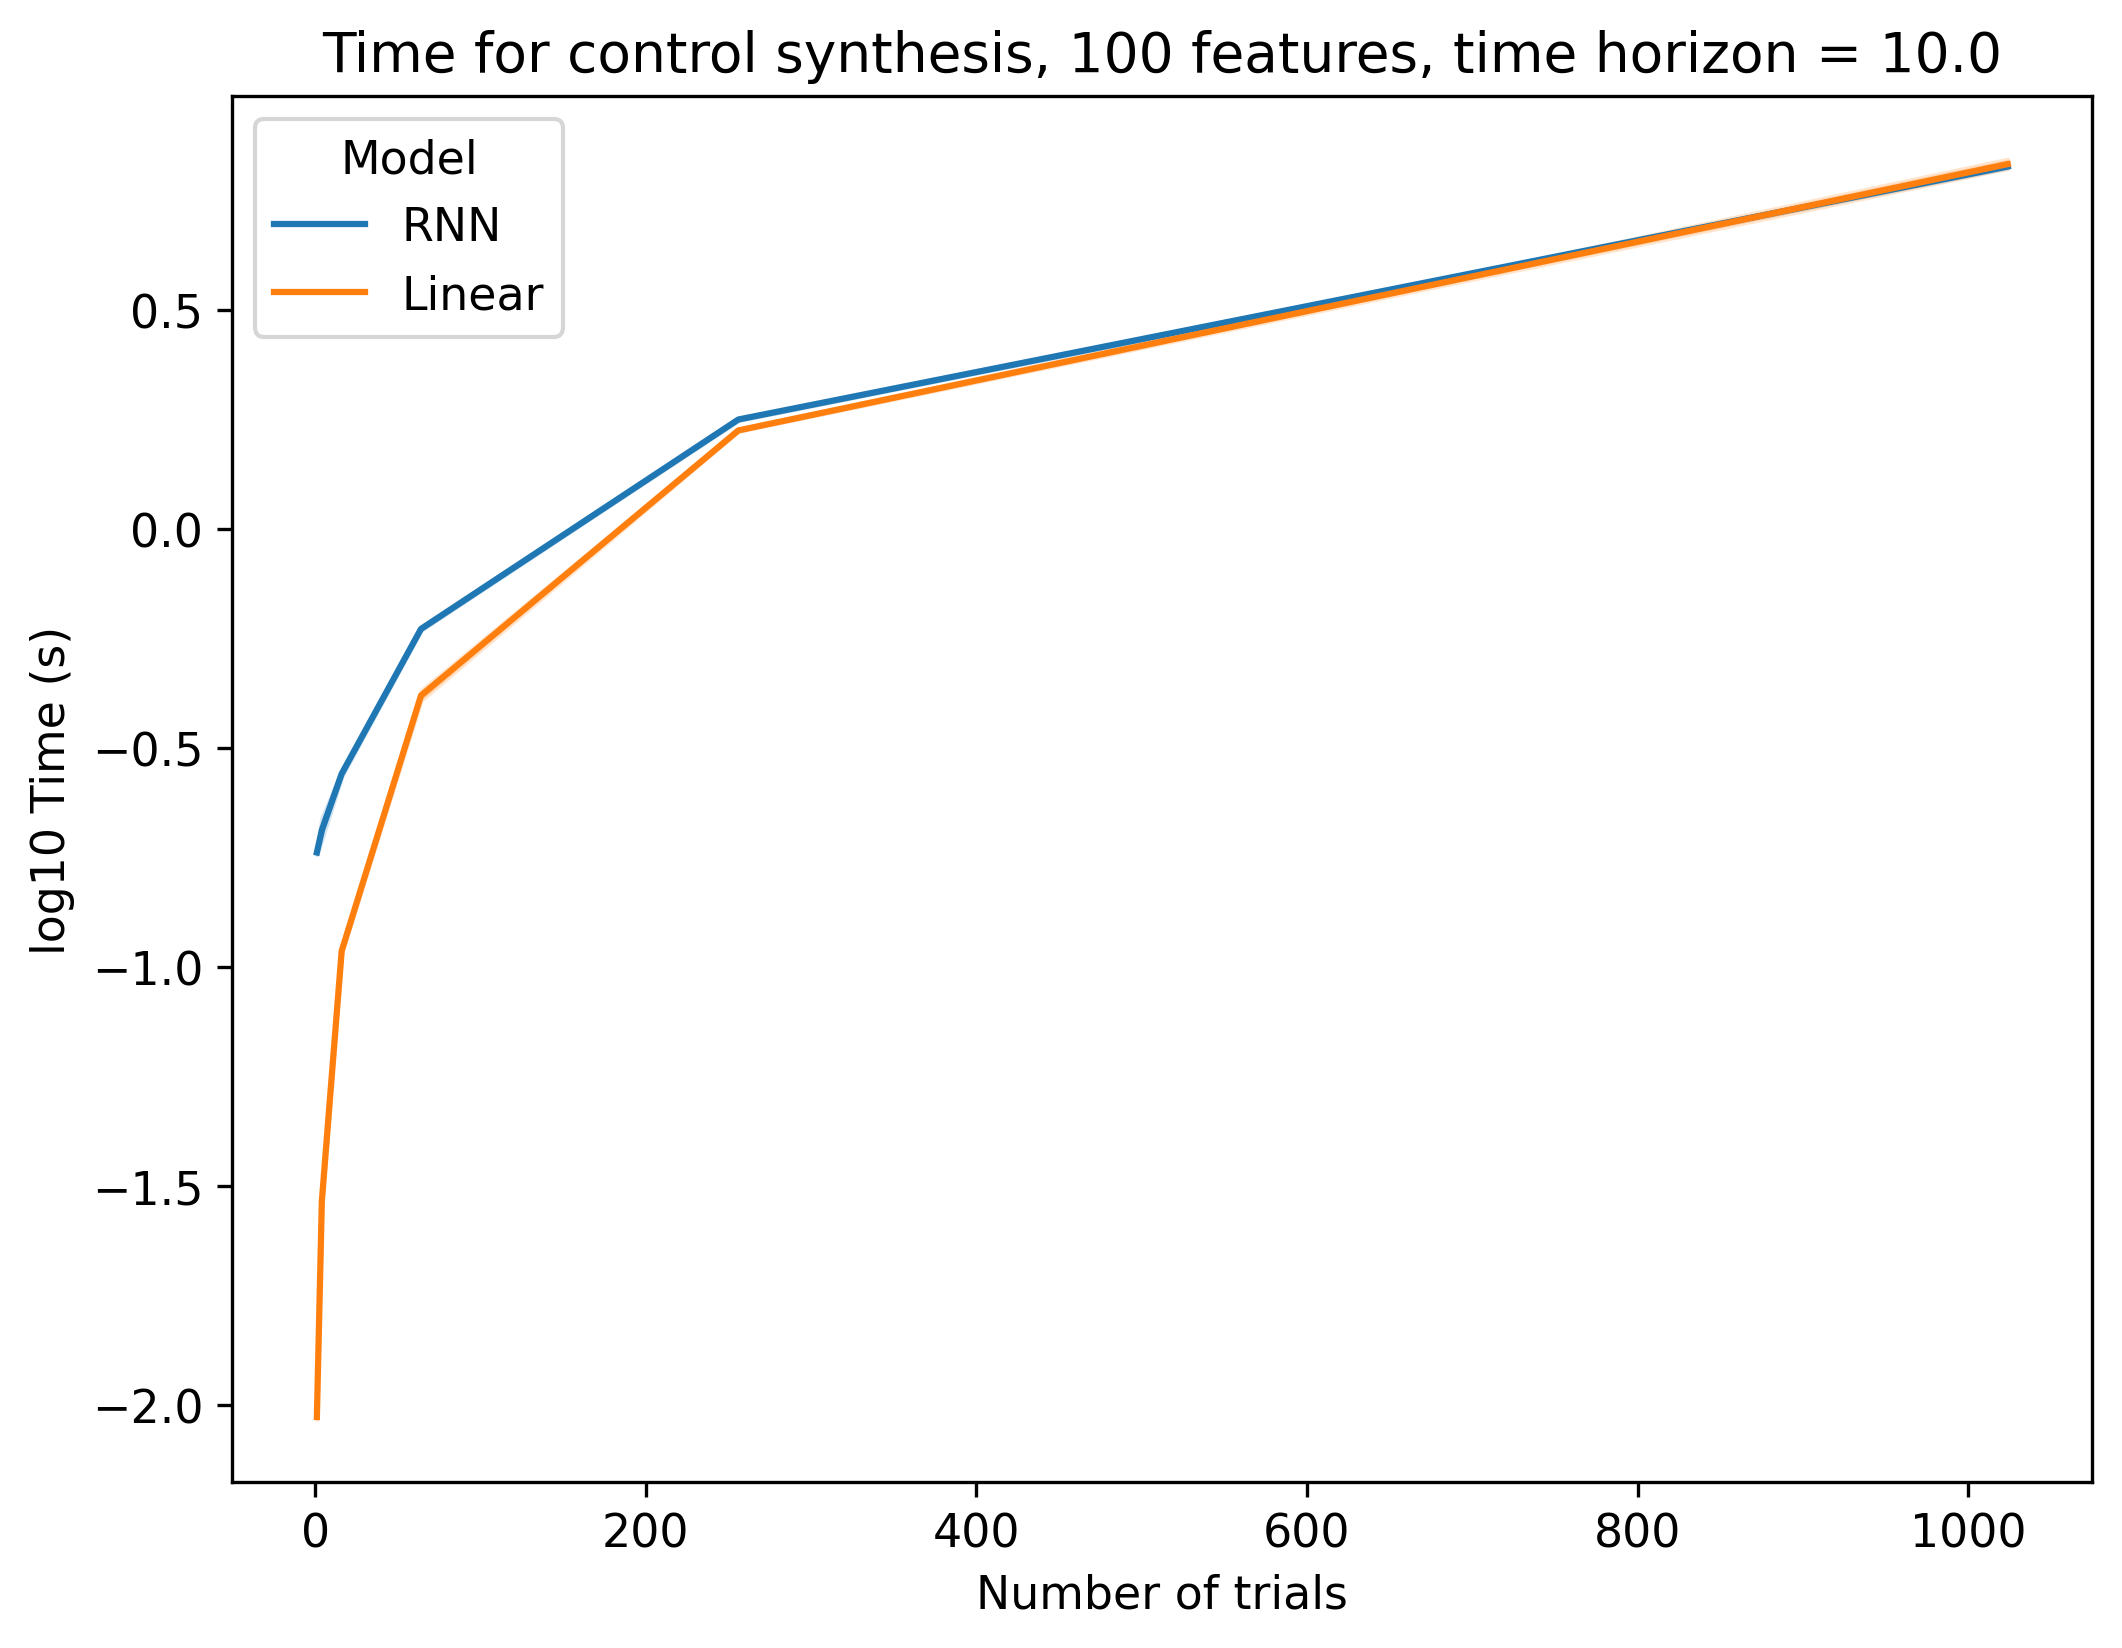

In [13]:
df['log_time'] = np.log10(df['time'])
sns.lineplot(data=df, x="n", y="log_time", hue="Model")
plt.xlabel("Number of trials")
plt.ylabel("log10 Time (s)")
plt.title(f"Time for control synthesis, {N} features, time horizon = {T}")
plt.savefig(os.path.join(figdir, "time_comparison_nTrials.pdf"))

Surprisingly, sometimes nonlinear synthesis can be faster than linear synthesis (note that they are for different systems). This might be due to the fact that under some error tolerance, neural ODE can be solved with fewer iterations than the computation needed to compute matrix exponential for linear synthesis.

### Dependence on the time horizon `T`

In [14]:
allT = [2. ** i for i in range(-2, 7)]
N = 100
n = 20
n_rep = 5

times = [pd.DataFrame(columns=["T", "time", "Model"])]

for T in allT:
    for _ in range(n_rep):
        print(f"T = {T}, Rep {_}")
        mdl = get_RNN(N, dvc=dvc)
        x0 = torch.randn(n, N, device=dvc)
        x1 = torch.randn(n, N, device=dvc)
        try:
            time = timeit(lambda: synthesize(mdl, x0, x1, T, method="forward_nominal_state"), number=1)
            times.append(pd.DataFrame({"T": T, "time": time, "Model": "RNN"}, index=[0]))
        except Exception as e:
            print(f"Error for T={T}, RNN: {e}")

        mdl = get_random_linear(N, dvc=dvc)
        try:
            time = timeit(lambda: synthesize(mdl, x0, x1, T, method="linearized"), number=1)
            times.append(pd.DataFrame({"T": T, "time": time, "Model": "Linear"}, index=[0]))
        except Exception as e:
            print(f"Error for T={T}, Linear: {e}")

df = pd.concat(times, ignore_index=True)

T = 0.25, Rep 0


T = 0.25, Rep 1
T = 0.25, Rep 2
T = 0.25, Rep 3
T = 0.25, Rep 4
T = 0.5, Rep 0
T = 0.5, Rep 1
T = 0.5, Rep 2
T = 0.5, Rep 3
T = 0.5, Rep 4
T = 1.0, Rep 0
T = 1.0, Rep 1
T = 1.0, Rep 2
T = 1.0, Rep 3
T = 1.0, Rep 4
T = 2.0, Rep 0
T = 2.0, Rep 1
T = 2.0, Rep 2
T = 2.0, Rep 3
T = 2.0, Rep 4
T = 4.0, Rep 0
T = 4.0, Rep 1
T = 4.0, Rep 2
T = 4.0, Rep 3
T = 4.0, Rep 4
T = 8.0, Rep 0
T = 8.0, Rep 1
T = 8.0, Rep 2
T = 8.0, Rep 3
T = 8.0, Rep 4
T = 16.0, Rep 0
T = 16.0, Rep 1
T = 16.0, Rep 2
T = 16.0, Rep 3
T = 16.0, Rep 4
T = 32.0, Rep 0
T = 32.0, Rep 1
T = 32.0, Rep 2
T = 32.0, Rep 3
T = 32.0, Rep 4
T = 64.0, Rep 0
T = 64.0, Rep 1
T = 64.0, Rep 2
T = 64.0, Rep 3
T = 64.0, Rep 4


/tmp/43544.tmpdir/ipykernel_413/1058595701.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(times, ignore_index=True)


In [15]:
df.to_csv(os.path.join(datdir, "synthesis_time_T.csv"))

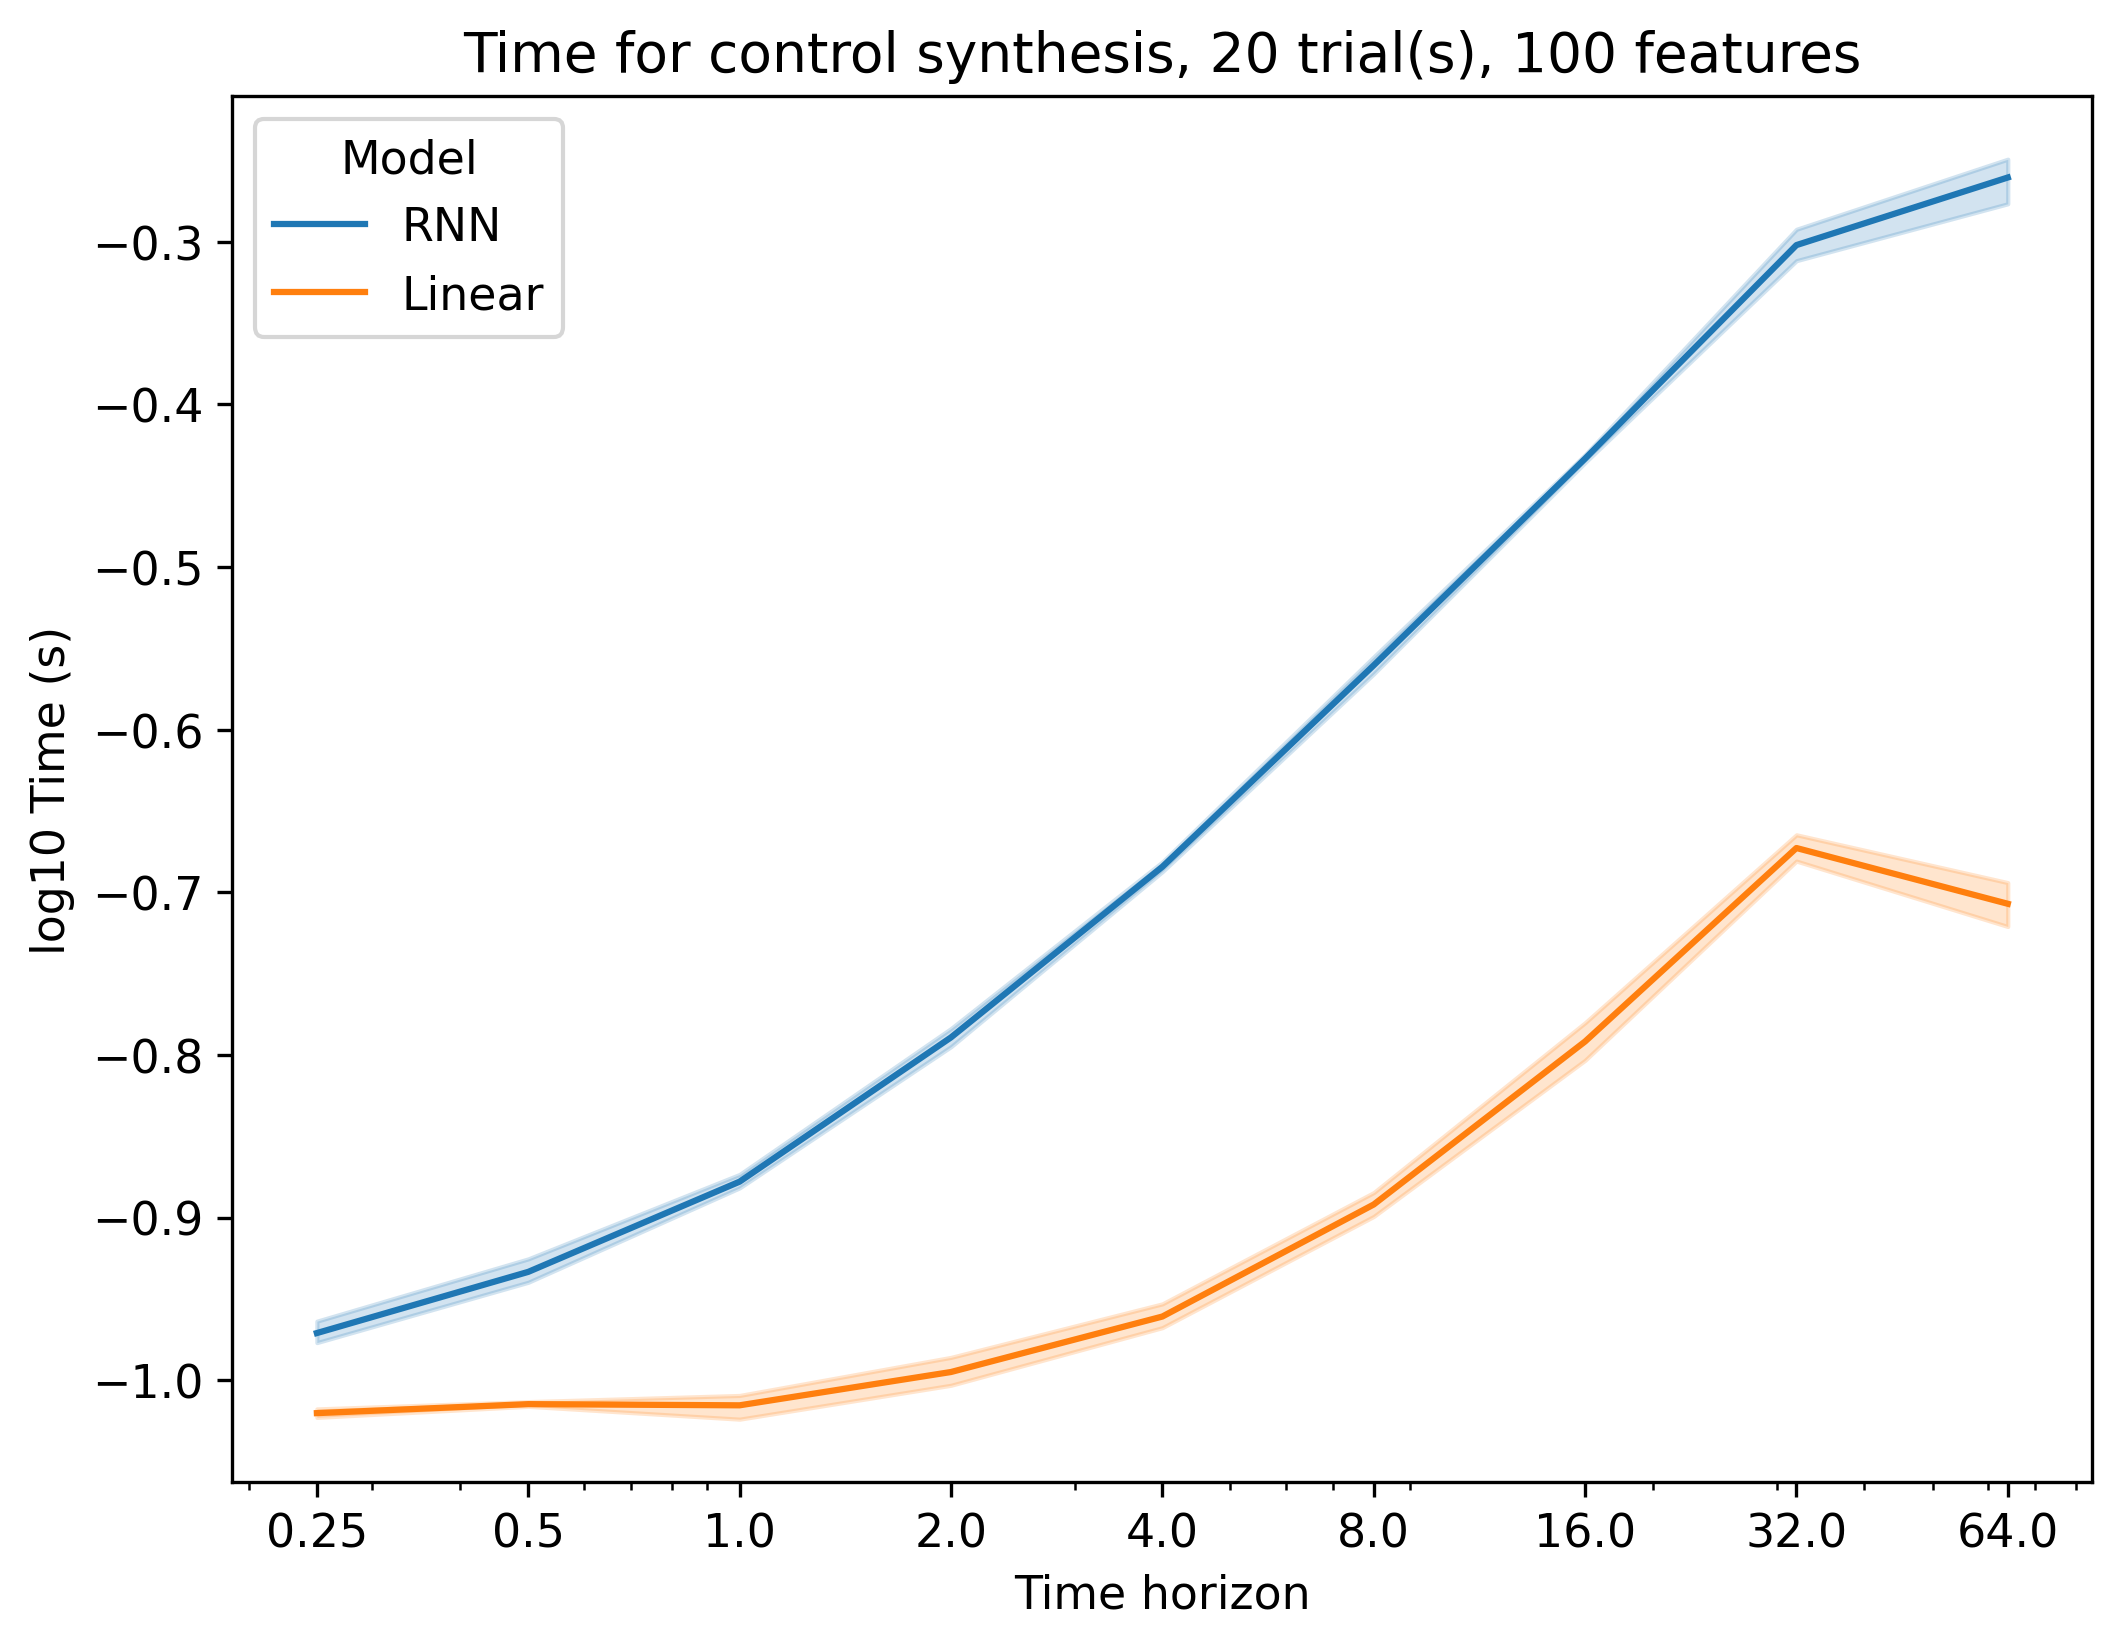

In [16]:
df['log_time'] = np.log10(df['time'])
ax = sns.lineplot(data=df, x="T", y="log_time", hue="Model")
plt.xscale("log")
ax.set_xticks(allT)
ax.set_xticklabels(allT)
plt.xlabel("Time horizon")
plt.ylabel("log10 Time (s)")
plt.title(f"Time for control synthesis, {n} trial(s), {N} features")
plt.savefig(os.path.join(figdir, "time_comparison_T.pdf"))